In [1]:
# Importing required packages
import numpy as np
import pandas as pd
from nltk.util import ngrams
from os import listdir
from os.path import isfile, join
import json
import time
import nltk
import re
from progressbar import ProgressBar
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import regexp_tokenize
import nltk.data 
import nltk
import matplotlib.pyplot as plt
import pickle
import networkx as nx
# Importing the packages required 
import gensim
from gensim.models import word2vec
import logging
# download the nltk packages required
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\surta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\surta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Extracting the data from the json files and storing in drive



In [3]:
path = 'C:/Users/surta/Downloads/pdf_json'
start = time.time()
filenames = [f for f in listdir(path) if isfile(join(path, f))]
end = time.time()

In [4]:
# Displaying the total number of json files in the shared drive folder
print("The total number of files found: ", len(filenames))

The total number of files found:  56528


In [5]:
def extract_text(text):
    title_meta = []
    title_meta.append(text['metadata']['title'])
    text_abstract = [text['abstract'][entry]['text'] for entry in range(len(text['abstract']))]
    text_bodytext = [text['body_text'][entry]['text'] for entry in range(len(text['body_text']))]

    full_text = title_meta + text_abstract + text_bodytext
    return full_text

final_text = []
for i in tqdm(range(len(filenames))):
    file_name = open(path+'/'+filenames[i])
    text = json.loads(file_name.read())
    final_text.append(extract_text(text))

100%|███████████████████████████████████████████████████████████████████████████| 56528/56528 [01:22<00:00, 681.31it/s]


In [6]:
final_str_text = [' '.join(final_text[i]) for i in range(len(final_text))]

Pre-processing steps

*   Lower casing
*   Remove Stop words

*   Remove punctuations like !()-[]{};:'"\,<>./?@#$%^&*_~
*   Remove website URLs
*   Remove non-alphanumeric characters i.e. everything except 
*   Remove numbers[0-9], letters and _


*   Remove strings which look like dates for e.g. **12/23/2016** and times **12:34:56**. Also remove strings which also are **am** or **pm** which are probably part of the preceding time in the source list
*   Lemmatization




In [7]:
def preprocessing(data):
    text_lower = data.lower()

    STOPWORDS = set(stopwords.words('english'))
    text_stop = " ".join([word for word in text_lower.split() if word not in STOPWORDS])

    text_punc = re.sub(r'[^\w\s^.]', '', text_stop)
    text_url = re.sub(r'https?://\S+|www\.\S+', '', text_punc)

    text_date = re.sub(r'^(?:(?:[0-9]{2}[:\/,]){2}[0-9]{2,4}|am|pm)$', '', text_url)
    
    # removing non-alphanumeric characters
    text_alnum = re.sub(r'\W+^.', ' ', text_date)

    # removing numbers (0-9)
    text_number = re.sub(r'[0-9]+', '', text_alnum)
    
    wordnet_lemmatizer = WordNetLemmatizer()
    text_lemma = " ".join([wordnet_lemmatizer.lemmatize(word) for word in text_number.split(" ")])

    return text_lemma

In [8]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\surta\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
with open('preprocessed_final_with_do.txt', 'w', encoding = 'utf8') as f:
    for item in tqdm(range(len(final_str_text))):
        if item != '':
            f.write("%s\n" % preprocessing(final_str_text[item]))

100%|████████████████████████████████████████████████████████████████████████████| 56528/56528 [16:30<00:00, 57.06it/s]


In [68]:
root = 'C:/Users/surta/Downloads/'
file_name = 'preprocessed_final_with_dot.txt'
path = root + file_name

## Building Word2Vec model

In [4]:
# Training the word2vec model on our text corpus using gensim
def compute_word_vectors(path): 
    '''
    computes the word vectors corresponding to the text corpus passed and returns the trained model
    '''
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    text = word2vec.Text8Corpus(path)
    model = word2vec.Word2Vec(text, vector_size = 128, window=5, min_count = 50, workers=10,)
    return model


In [9]:
# stores the trained word2vec model
model2 = compute_word_vectors(path)

2022-05-18 12:28:12,761 : INFO : collecting all words and their counts
2022-05-18 12:28:12,775 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-05-18 12:28:53,288 : INFO : PROGRESS: at sentence #10000, processed 100000000 words, keeping 1322636 word types
2022-05-18 12:29:11,181 : INFO : collected 1658523 word types from a corpus of 139777989 raw words and 13978 sentences
2022-05-18 12:29:11,182 : INFO : Creating a fresh vocabulary
2022-05-18 12:29:12,261 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=50 retains 75323 unique words (4.541571024339126%% of original 1658523, drops 1583200)', 'datetime': '2022-05-18T12:29:12.260615', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
2022-05-18 12:29:12,261 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=50 leaves 133957731 word corpus (95.83606972625711%% of origin

2022-05-18 12:30:05,201 : INFO : EPOCH 1 - PROGRESS: at 30.77% examples, 779562 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:30:06,202 : INFO : EPOCH 1 - PROGRESS: at 31.36% examples, 779357 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:30:07,215 : INFO : EPOCH 1 - PROGRESS: at 31.95% examples, 778560 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:30:08,216 : INFO : EPOCH 1 - PROGRESS: at 32.54% examples, 778195 words/s, in_qsize 0, out_qsize 1
2022-05-18 12:30:09,217 : INFO : EPOCH 1 - PROGRESS: at 33.14% examples, 778195 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:30:10,233 : INFO : EPOCH 1 - PROGRESS: at 33.72% examples, 777709 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:30:11,246 : INFO : EPOCH 1 - PROGRESS: at 34.31% examples, 777297 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:30:12,256 : INFO : EPOCH 1 - PROGRESS: at 34.90% examples, 776964 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:30:13,260 : INFO : EPOCH 1 - PROGRESS: at 35.48% examples, 776698 words/s, in_qsiz

2022-05-18 12:31:18,901 : INFO : EPOCH 1 - PROGRESS: at 73.15% examples, 760845 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:31:19,906 : INFO : EPOCH 1 - PROGRESS: at 73.72% examples, 760706 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:31:20,915 : INFO : EPOCH 1 - PROGRESS: at 74.29% examples, 760448 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:31:21,921 : INFO : EPOCH 1 - PROGRESS: at 74.86% examples, 760272 words/s, in_qsize 1, out_qsize 0
2022-05-18 12:31:22,934 : INFO : EPOCH 1 - PROGRESS: at 75.42% examples, 759928 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:31:23,935 : INFO : EPOCH 1 - PROGRESS: at 75.97% examples, 759609 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:31:24,936 : INFO : EPOCH 1 - PROGRESS: at 76.55% examples, 759525 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:31:25,939 : INFO : EPOCH 1 - PROGRESS: at 77.16% examples, 759768 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:31:26,939 : INFO : EPOCH 1 - PROGRESS: at 77.74% examples, 759730 words/s, in_qsiz

2022-05-18 12:32:23,841 : INFO : EPOCH 2 - PROGRESS: at 9.54% examples, 724798 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:32:24,852 : INFO : EPOCH 2 - PROGRESS: at 10.12% examples, 726568 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:32:25,859 : INFO : EPOCH 2 - PROGRESS: at 10.72% examples, 729270 words/s, in_qsize 0, out_qsize 1
2022-05-18 12:32:26,859 : INFO : EPOCH 2 - PROGRESS: at 11.28% examples, 729136 words/s, in_qsize 0, out_qsize 1
2022-05-18 12:32:27,861 : INFO : EPOCH 2 - PROGRESS: at 11.85% examples, 729767 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:32:28,868 : INFO : EPOCH 2 - PROGRESS: at 12.44% examples, 731226 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:32:29,874 : INFO : EPOCH 2 - PROGRESS: at 13.05% examples, 733709 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:32:30,888 : INFO : EPOCH 2 - PROGRESS: at 13.62% examples, 733825 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:32:31,895 : INFO : EPOCH 2 - PROGRESS: at 14.19% examples, 734141 words/s, in_qsize

2022-05-18 12:33:37,492 : INFO : EPOCH 2 - PROGRESS: at 53.78% examples, 771072 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:33:38,513 : INFO : EPOCH 2 - PROGRESS: at 54.56% examples, 773663 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:33:39,514 : INFO : EPOCH 2 - PROGRESS: at 55.37% examples, 776683 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:33:40,517 : INFO : EPOCH 2 - PROGRESS: at 56.15% examples, 778990 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:33:41,525 : INFO : EPOCH 2 - PROGRESS: at 56.95% examples, 781775 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:33:42,534 : INFO : EPOCH 2 - PROGRESS: at 57.60% examples, 782334 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:33:43,540 : INFO : EPOCH 2 - PROGRESS: at 58.41% examples, 785057 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:33:44,543 : INFO : EPOCH 2 - PROGRESS: at 59.20% examples, 787568 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:33:45,552 : INFO : EPOCH 2 - PROGRESS: at 60.02% examples, 790379 words/s, in_qsiz

2022-05-18 12:34:41,958 : INFO : EPOCH - 2 : training on 139777989 raw words (130096429 effective words) took 155.3s, 837976 effective words/s
2022-05-18 12:34:42,975 : INFO : EPOCH 3 - PROGRESS: at 0.63% examples, 816122 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:34:43,990 : INFO : EPOCH 3 - PROGRESS: at 1.32% examples, 846731 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:34:44,993 : INFO : EPOCH 3 - PROGRESS: at 2.10% examples, 906715 words/s, in_qsize 0, out_qsize 1
2022-05-18 12:34:46,008 : INFO : EPOCH 3 - PROGRESS: at 2.83% examples, 912021 words/s, in_qsize 0, out_qsize 1
2022-05-18 12:34:47,018 : INFO : EPOCH 3 - PROGRESS: at 3.45% examples, 890796 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:34:48,025 : INFO : EPOCH 3 - PROGRESS: at 4.08% examples, 880534 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:34:49,035 : INFO : EPOCH 3 - PROGRESS: at 4.79% examples, 885524 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:34:50,040 : INFO : EPOCH 3 - PROGRESS: at 5.39% examples, 8

2022-05-18 12:35:55,667 : INFO : EPOCH 3 - PROGRESS: at 48.92% examples, 863775 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:35:56,677 : INFO : EPOCH 3 - PROGRESS: at 49.61% examples, 864257 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:35:57,694 : INFO : EPOCH 3 - PROGRESS: at 50.39% examples, 865983 words/s, in_qsize 0, out_qsize 1
2022-05-18 12:35:58,708 : INFO : EPOCH 3 - PROGRESS: at 51.11% examples, 866861 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:35:59,709 : INFO : EPOCH 3 - PROGRESS: at 51.82% examples, 867683 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:36:00,716 : INFO : EPOCH 3 - PROGRESS: at 52.51% examples, 867972 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:36:01,725 : INFO : EPOCH 3 - PROGRESS: at 53.24% examples, 868954 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:36:02,726 : INFO : EPOCH 3 - PROGRESS: at 53.86% examples, 868112 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:36:03,735 : INFO : EPOCH 3 - PROGRESS: at 54.48% examples, 867307 words/s, in_qsiz

2022-05-18 12:37:09,274 : INFO : EPOCH 3 - PROGRESS: at 95.80% examples, 846125 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:37:10,278 : INFO : EPOCH 3 - PROGRESS: at 96.60% examples, 847455 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:37:11,293 : INFO : EPOCH 3 - PROGRESS: at 97.40% examples, 848642 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:37:12,303 : INFO : EPOCH 3 - PROGRESS: at 98.21% examples, 849922 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:37:13,312 : INFO : EPOCH 3 - PROGRESS: at 99.01% examples, 851133 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:37:14,319 : INFO : EPOCH 3 - PROGRESS: at 99.81% examples, 852362 words/s, in_qsize 0, out_qsize 1
2022-05-18 12:37:14,498 : INFO : worker thread finished; awaiting finish of 9 more threads
2022-05-18 12:37:14,508 : INFO : worker thread finished; awaiting finish of 8 more threads
2022-05-18 12:37:14,509 : INFO : worker thread finished; awaiting finish of 7 more threads
2022-05-18 12:37:14,511 : INFO : worker thread fi

2022-05-18 12:38:13,976 : INFO : EPOCH 4 - PROGRESS: at 39.10% examples, 856069 words/s, in_qsize 1, out_qsize 0
2022-05-18 12:38:14,995 : INFO : EPOCH 4 - PROGRESS: at 39.68% examples, 854239 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:38:16,009 : INFO : EPOCH 4 - PROGRESS: at 40.30% examples, 853165 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:38:17,025 : INFO : EPOCH 4 - PROGRESS: at 40.87% examples, 851228 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:38:18,030 : INFO : EPOCH 4 - PROGRESS: at 41.47% examples, 849910 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:38:19,042 : INFO : EPOCH 4 - PROGRESS: at 42.07% examples, 848679 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:38:20,065 : INFO : EPOCH 4 - PROGRESS: at 42.58% examples, 845521 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:38:21,073 : INFO : EPOCH 4 - PROGRESS: at 43.12% examples, 843373 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:38:22,087 : INFO : EPOCH 4 - PROGRESS: at 43.71% examples, 842055 words/s, in_qsiz

2022-05-18 12:39:27,670 : INFO : EPOCH 4 - PROGRESS: at 88.24% examples, 862406 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:39:28,676 : INFO : EPOCH 4 - PROGRESS: at 89.00% examples, 863343 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:39:29,686 : INFO : EPOCH 4 - PROGRESS: at 89.73% examples, 863945 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:39:30,712 : INFO : EPOCH 4 - PROGRESS: at 90.46% examples, 864351 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:39:31,712 : INFO : EPOCH 4 - PROGRESS: at 91.11% examples, 864184 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:39:32,714 : INFO : EPOCH 4 - PROGRESS: at 91.87% examples, 865084 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:39:33,715 : INFO : EPOCH 4 - PROGRESS: at 92.62% examples, 865878 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:39:34,727 : INFO : EPOCH 4 - PROGRESS: at 93.35% examples, 866289 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:39:35,735 : INFO : EPOCH 4 - PROGRESS: at 93.91% examples, 865335 words/s, in_qsiz

2022-05-18 12:40:32,895 : INFO : EPOCH 5 - PROGRESS: at 34.86% examples, 939052 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:40:33,906 : INFO : EPOCH 5 - PROGRESS: at 35.43% examples, 934728 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:40:34,916 : INFO : EPOCH 5 - PROGRESS: at 35.96% examples, 929795 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:40:35,921 : INFO : EPOCH 5 - PROGRESS: at 36.58% examples, 927088 words/s, in_qsize 1, out_qsize 0
2022-05-18 12:40:36,931 : INFO : EPOCH 5 - PROGRESS: at 37.21% examples, 924867 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:40:37,932 : INFO : EPOCH 5 - PROGRESS: at 37.85% examples, 922986 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:40:38,940 : INFO : EPOCH 5 - PROGRESS: at 38.52% examples, 922155 words/s, in_qsize 0, out_qsize 1
2022-05-18 12:40:39,958 : INFO : EPOCH 5 - PROGRESS: at 39.20% examples, 920964 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:40:40,963 : INFO : EPOCH 5 - PROGRESS: at 39.88% examples, 920107 words/s, in_qsiz

2022-05-18 12:41:46,687 : INFO : EPOCH 5 - PROGRESS: at 77.14% examples, 821963 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:41:47,720 : INFO : EPOCH 5 - PROGRESS: at 77.66% examples, 820577 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:41:48,755 : INFO : EPOCH 5 - PROGRESS: at 78.07% examples, 818026 words/s, in_qsize 0, out_qsize 1
2022-05-18 12:41:49,766 : INFO : EPOCH 5 - PROGRESS: at 78.60% examples, 816972 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:41:50,773 : INFO : EPOCH 5 - PROGRESS: at 79.22% examples, 816879 words/s, in_qsize 0, out_qsize 1
2022-05-18 12:41:51,775 : INFO : EPOCH 5 - PROGRESS: at 79.83% examples, 816665 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:41:52,786 : INFO : EPOCH 5 - PROGRESS: at 80.54% examples, 817441 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:41:53,803 : INFO : EPOCH 5 - PROGRESS: at 81.26% examples, 818312 words/s, in_qsize 0, out_qsize 0
2022-05-18 12:41:54,812 : INFO : EPOCH 5 - PROGRESS: at 82.04% examples, 819754 words/s, in_qsiz

In [10]:
# save the model on drive
model.save(root+'model_NLP_word2vec.bin')

2022-05-18 12:56:35,851 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'C:/Users/surta/Downloads/model_NLP.bin', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-05-18T12:56:35.851612', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'saving'}
2022-05-18 12:56:35,852 : INFO : not storing attribute cum_table
2022-05-18 12:56:36,016 : INFO : saved C:/Users/surta/Downloads/model_NLP.bin


In [70]:
# load the trained word2vec model from drive
model = word2vec.Word2Vec.load(root + 'model_NLP_word2vec.bin')

In [13]:
# returns the 'topn' number of similar words to the 'source_word' passed
def compute_similar_words(model,source_word, topn=5):
    
    print('Computing similar words for the source word - {0}'.format(source_word),end='')
    similar_words = [source_word]
    try:
        top_words = model.wv.most_similar(source_word,topn=topn)
        similar_words.extend([val[0] for val in top_words])
    except KeyError as err:
        print(err.args)
    return similar_words   

def compute_similar_words_for_assignment3(model, keywords, levels = 2): #model - Word2vec model stored earlier 
    '''
    creates the df corresponding to the similar words to be displayed in the graph
    '''
    columns = ['word'+str(i-1) for i in range(1,7)]
    df = pd.DataFrame(data=None,columns=columns)

    for source_word in keywords:
        similar_words = compute_similar_words(model,source_word)
        df.loc[len(df)] = similar_words
        
        for i in range(1,len(similar_words)):
            sec_similar_words = compute_similar_words(model,similar_words[i])
            df.loc[len(df)] = sec_similar_words

            if levels >=3: 
                for j in range(1,len(sec_similar_words)):
                    three_similar_words = compute_similar_words(model,sec_similar_words[j])
                    df.loc[len(df)] = three_similar_words

                if levels >=4:
                    for k in range(1,len(three_similar_words)):
                        four_similar_words = compute_similar_words(model,three_similar_words[k])
                        df.loc[len(df)] = four_similar_words
                    
                    if levels >= 5:
                        for k in range(1, len(four_similar_words)):
                            five_similar_words = compute_similar_words(model, four_similar_words[k])
                            df.loc[len(df)] = five_similar_words
    return df

In [32]:
# The keywords with which the graph is to be generated
keys = ['sarscov', 'herd', 'respiratory', 'immunization', 'swine', 'preparedness', 'lung', 'symptom', 'transmission', 'infectious']
# Creating the df of similar words
sim_words = compute_similar_words_for_assignment3(model, keywords = keys, levels = 3)

 Computing similar words for the source word - aujeszkysuthlleble

In [33]:
# saving the df to a csv file
sim_words.to_csv('keywords.csv')

# reading the csv file back again
keywords = pd.read_csv('keywords.csv')

In [34]:
# display the first few rows of the df
keywords.head(10)

Unnamed: 0    word0    word1    word2          word3        word4     word5
0           0  sarscov  merscov   sarcov           ncov          cov  sarscov.
1           1  merscov  sarscov      cov           mers       sarcov      ncov
2           2  sarscov  merscov   sarcov           ncov          cov  sarscov.
3           3      cov     covs  merscov  coronaviruses  coronavirus   sarscov
4           4     mers     sars  merscov          mers.          cov      ncov
5           5   sarcov  sarscov     ncov        merscov          cov   srascov
6           6     ncov  sarscov   sarcov        merscov         sars      mers
7           7   sarcov  sarscov     ncov        merscov          cov   srascov
8           8  sarscov  merscov   sarcov           ncov          cov  sarscov.
9           9     ncov  sarscov   sarcov        merscov         sars      mers

## Example: Finding the words similar to a given word 

In [35]:
# Choose a word and display the top n words which are similar to the word in our text corpus
choose_word = 'gene'
words_sim = compute_similar_words(model2, choose_word, topn = 11)
print('\nThe top 10 list of words similar to the word ', choose_word, ' are:')
print(words_sim[2:])

 Computing similar words for the source word - gene
The top 10 list of words similar to the word  gene  are:
['gene.', 'locus', 'protein', 'transcript', 'paralogs', 'protooncogenes', 'pseudogenes', 'herv', 'hipab', 'rhifitm']


## Knowledge graph (combined)

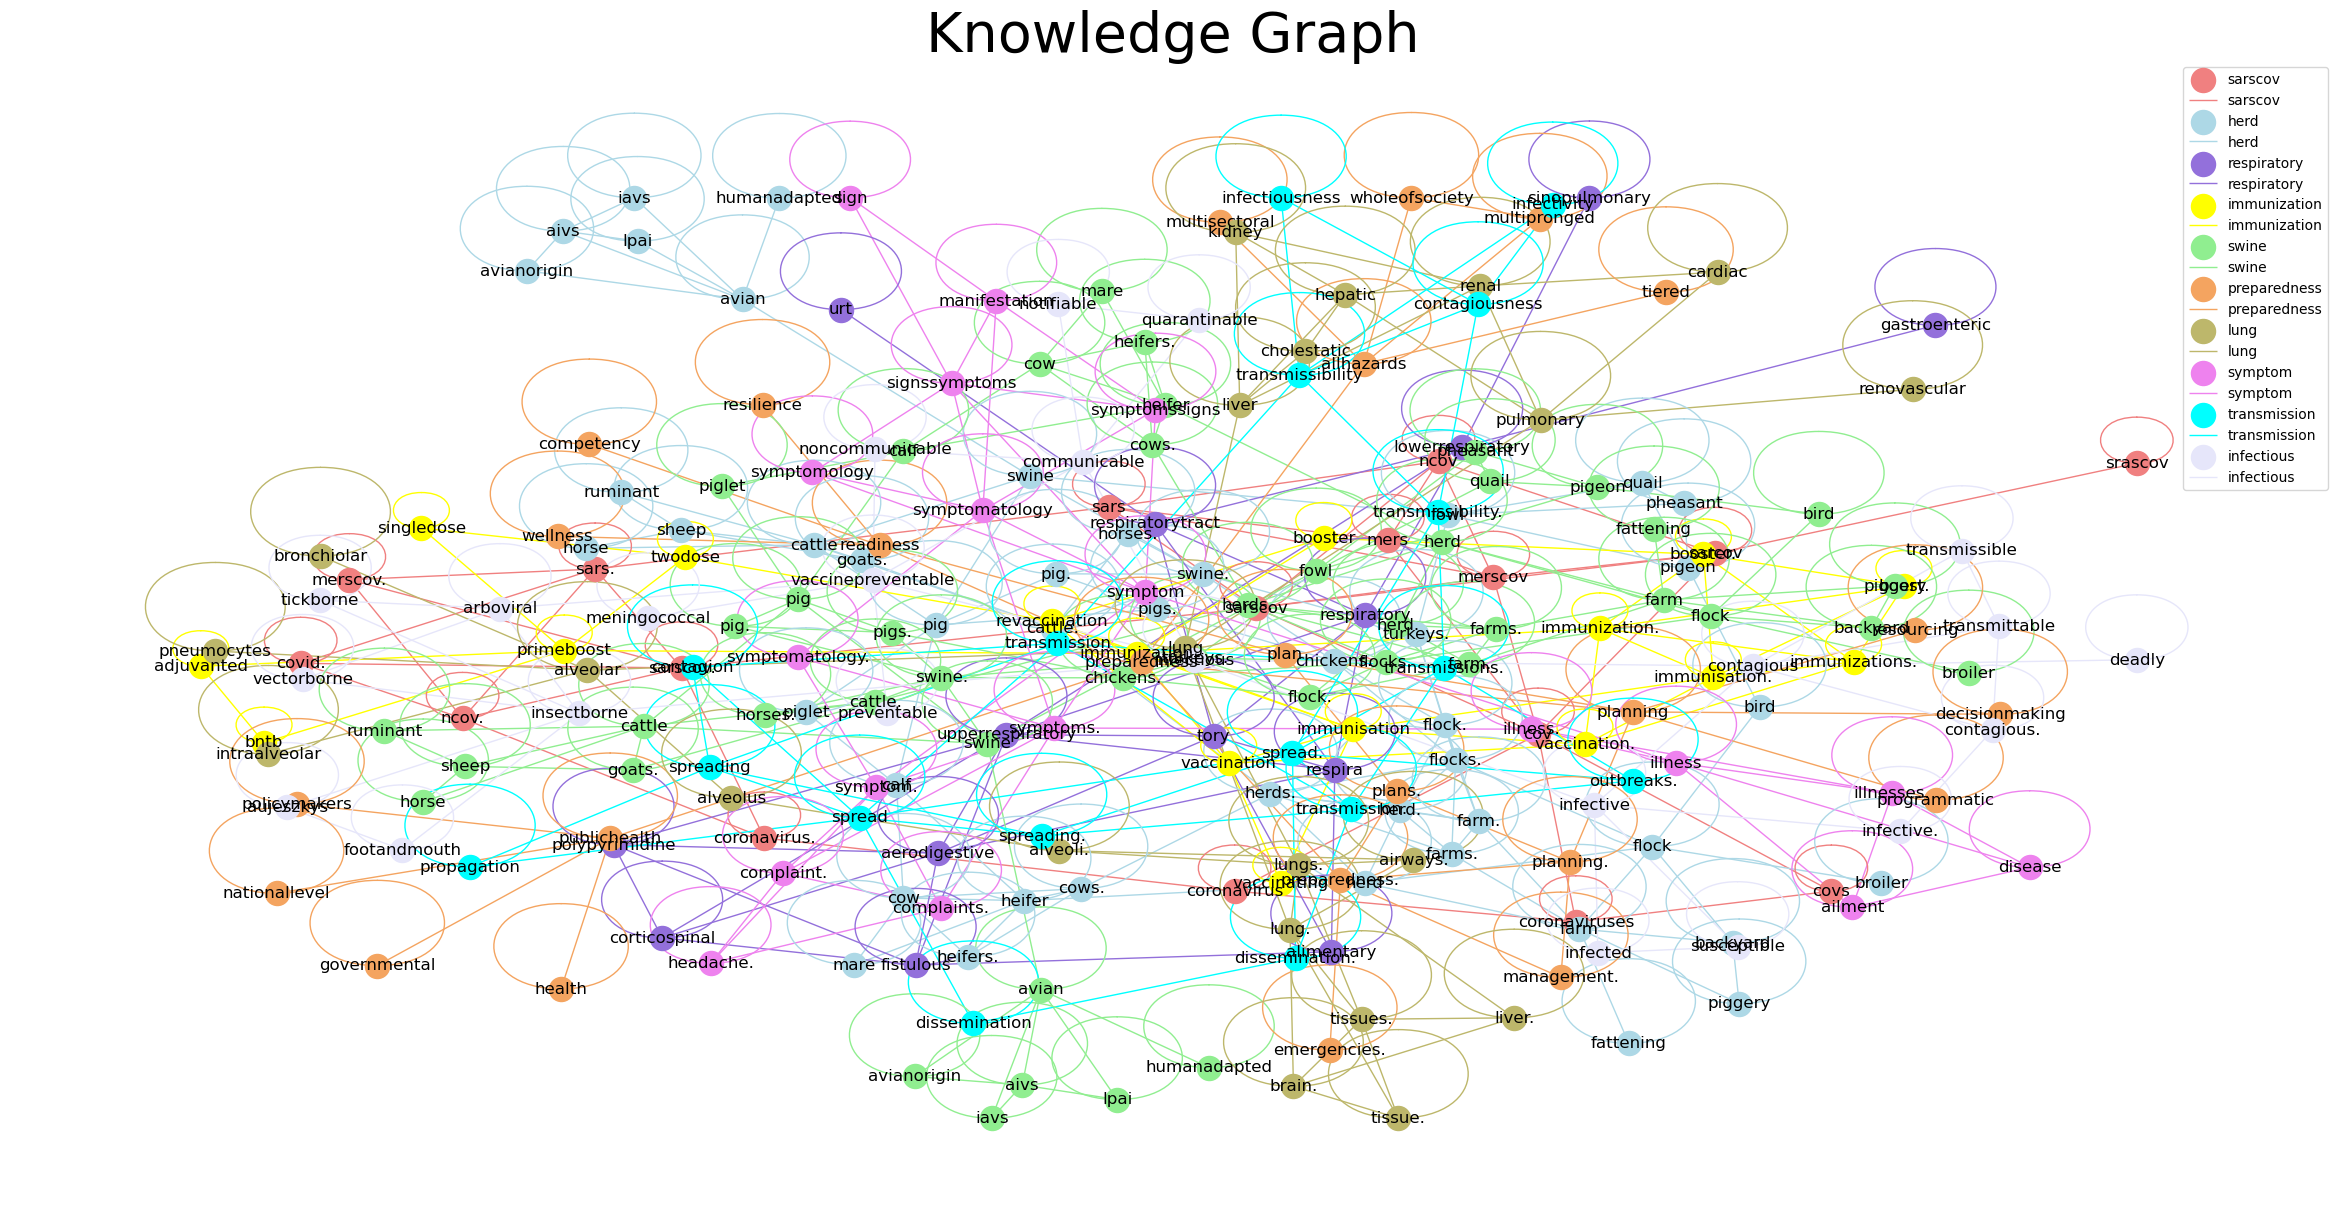

In [66]:
# Storing the csv file
words = keywords

# Initializing the graph
g = nx.cubical_graph()

#Construct the graph
#for every source word(node), add edges - connected through similarity
#As there two levels of similar words, we need to repeat the same to construct the graph
for i, row in words.iterrows():
    for j in range(1,len(row)):
        g.add_node(row[j])
    for j in range(1,len(row)):
        g.add_edge(row[1], row[j])    
      
G = nx.petersen_graph()
plt.subplot()

colors = ['lightcoral', 'lightblue', 'mediumpurple', 'yellow', 'lightgreen', 'sandybrown', 'darkkhaki', 'violet', 'cyan', 'lavender']

#make sure to filter nodes based on the degree of connectivity
#and pick up nodes that are well connected. The number of connected concepts can be tuned using 
#the filter given below

fedges = filter(lambda x: g.degree()[x[0]] > 5 and g.degree()[x[1]] > 5, g.edges())
f = nx.Graph()                                                                                                                                     
f.add_edges_from(fedges)

#This is to show how well the keyword is connected with the other words in the corpus  
#change the keyword to obtain a different graph
#you do not need this while running the entire no
plt.rcParams['figure.figsize'] = [30, 15]

# iterating over all the keywords
for word in range(len(keys)):
  subgraph = nx.node_connected_component(f,keys[word])
  print()
  nx.draw(g.subgraph(subgraph), with_labels = True, node_color = colors[word], edge_color = colors[word], label = keys[word])

plt.title('Knowledge Graph', fontsize = 40)
plt.legend()
plt.savefig(root+"knowledge_graph.pdf")
plt.show()

## Individual knowledge graphs

In [55]:
# Initializing options
options = {
    'node_color': 'red',
    # 'node_size': 100,
    'linewidths': 0.3,
    'width': 0.5,
    'font_size': 20,
}

### Sarscov

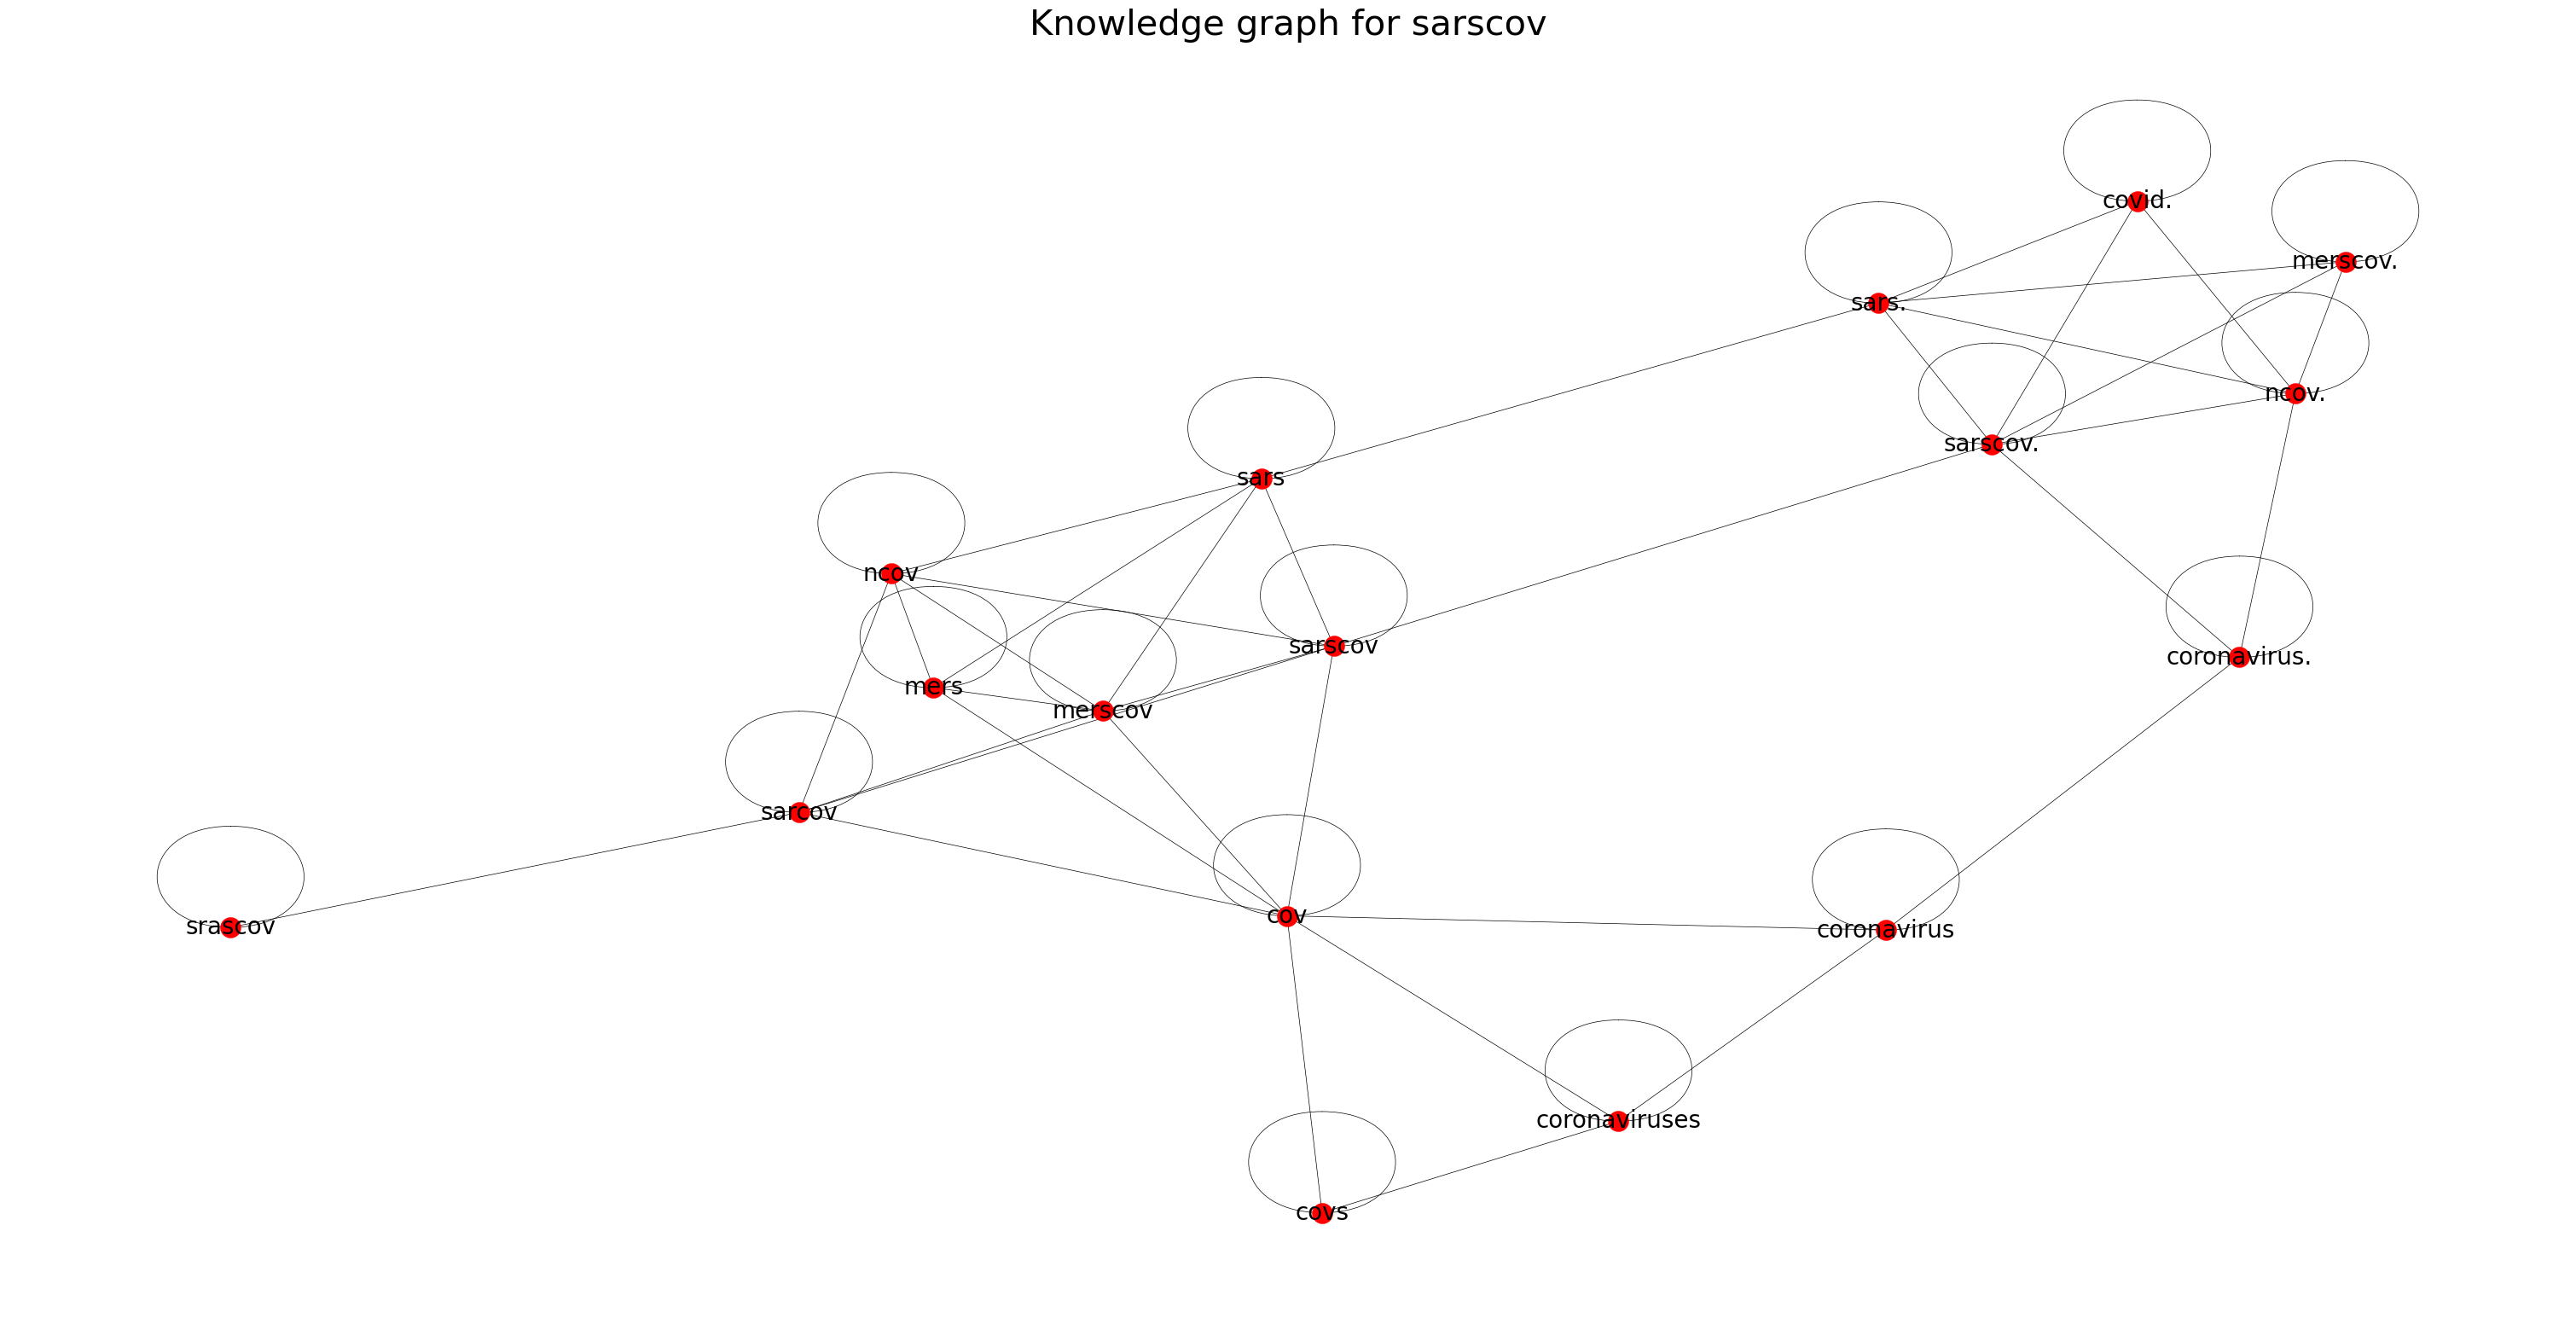

In [56]:
subgraph = nx.node_connected_component(f,'sarscov')
print()
nx.draw(g.subgraph(subgraph), with_labels=True, **options)
plt.title('Knowledge graph for sarscov', fontsize = 30)
plt.show()

### Herd

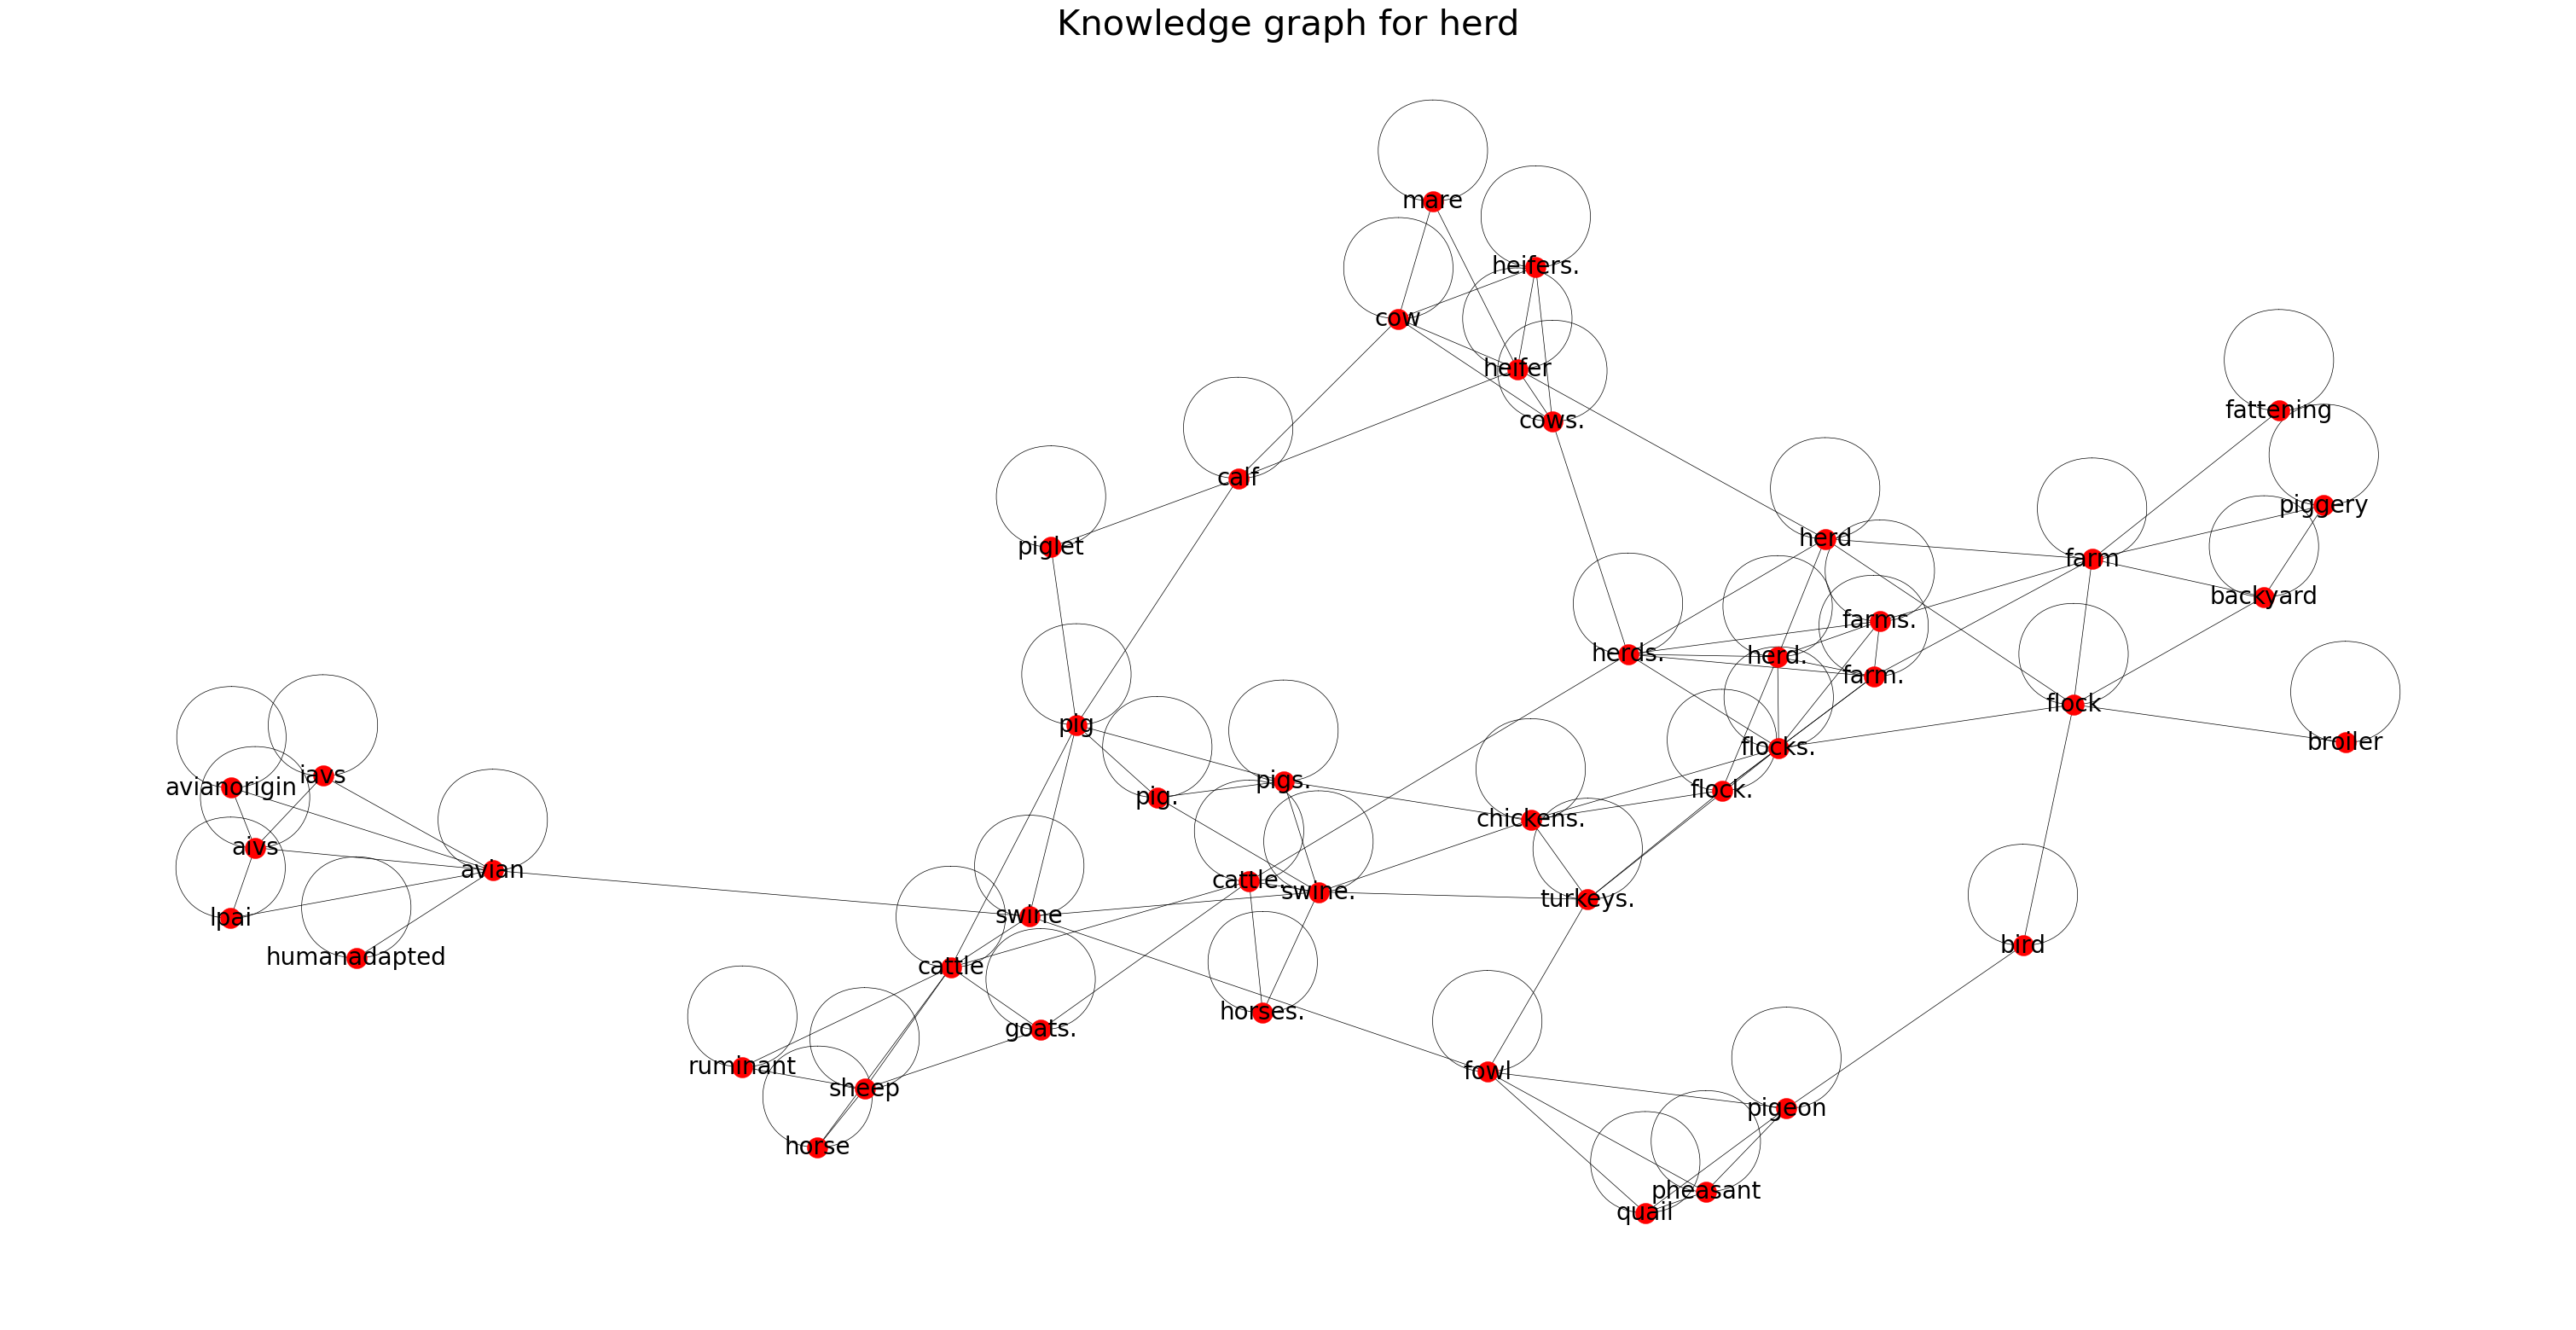

In [57]:
subgraph = nx.node_connected_component(f, 'herd')
print()
nx.draw(g.subgraph(subgraph), with_labels = True, **options)
plt.title('Knowledge graph for herd', fontsize = 30)
plt.show()

### Respiratory

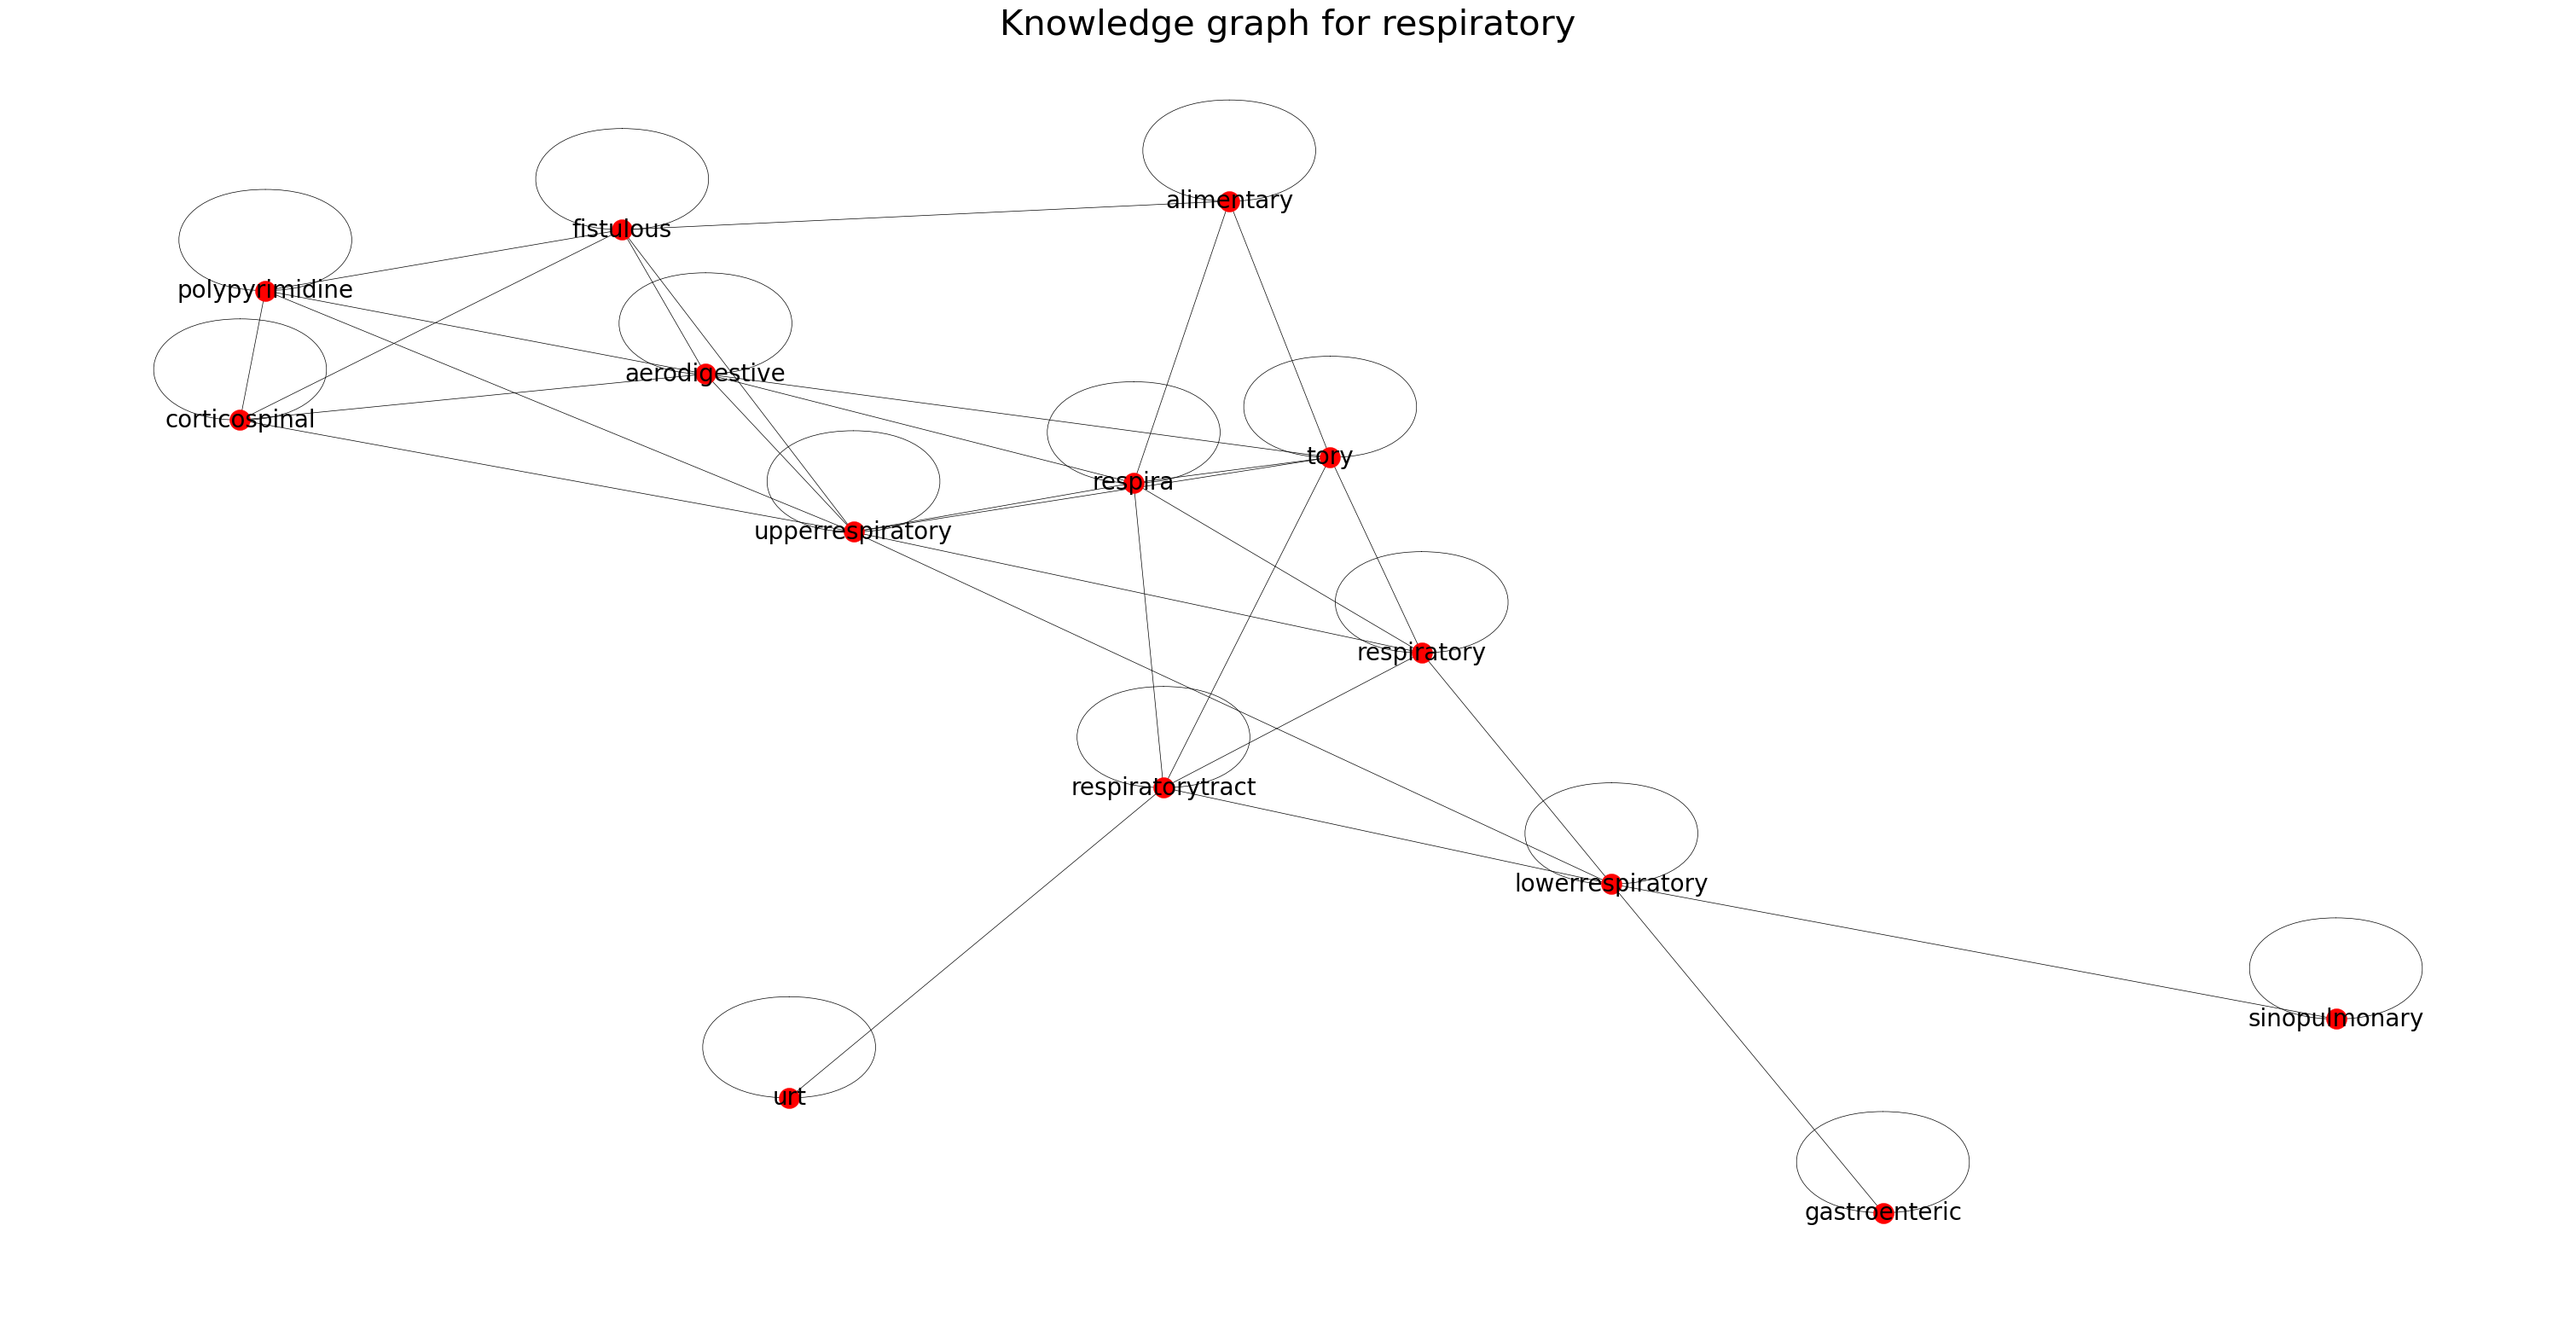

In [58]:
subgraph = nx.node_connected_component(f,'respiratory')
print()
nx.draw(g.subgraph(subgraph), with_labels=True, **options)
plt.title('Knowledge graph for respiratory', fontsize = 30)
plt.show()

### Immunization

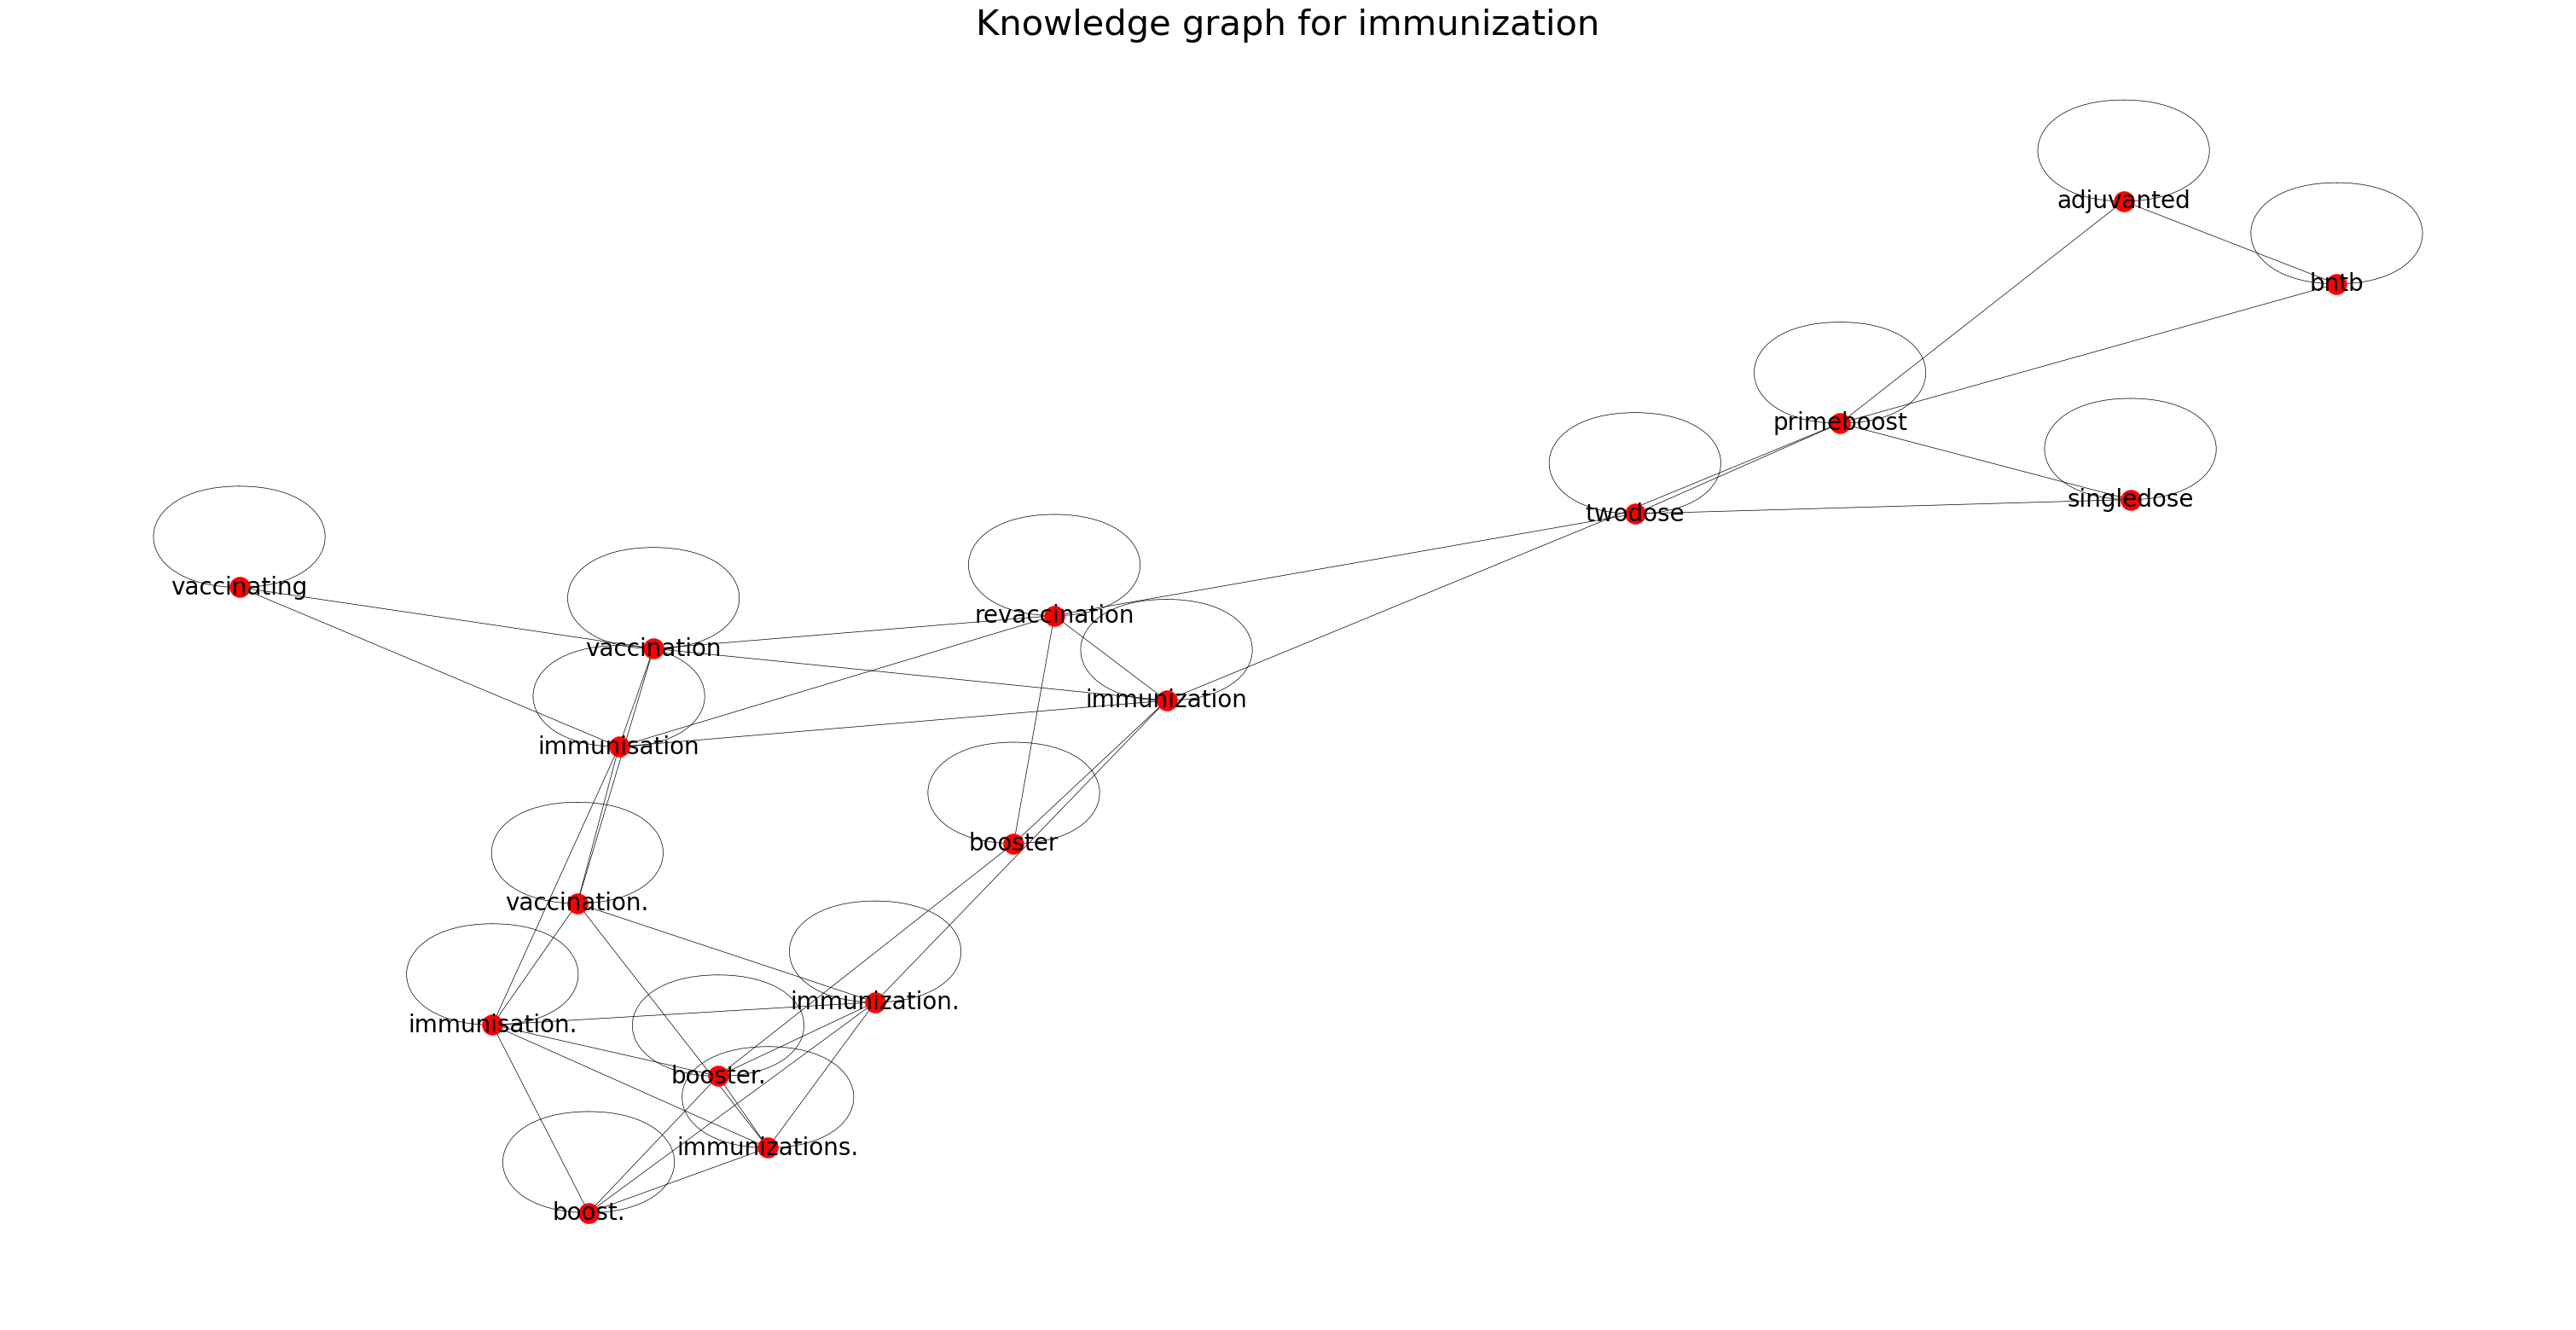

In [59]:
subgraph = nx.node_connected_component(f,'immunization')
print()
nx.draw(g.subgraph(subgraph), with_labels=True, **options)
plt.title('Knowledge graph for immunization', fontsize = 30)
plt.show()

### Swine

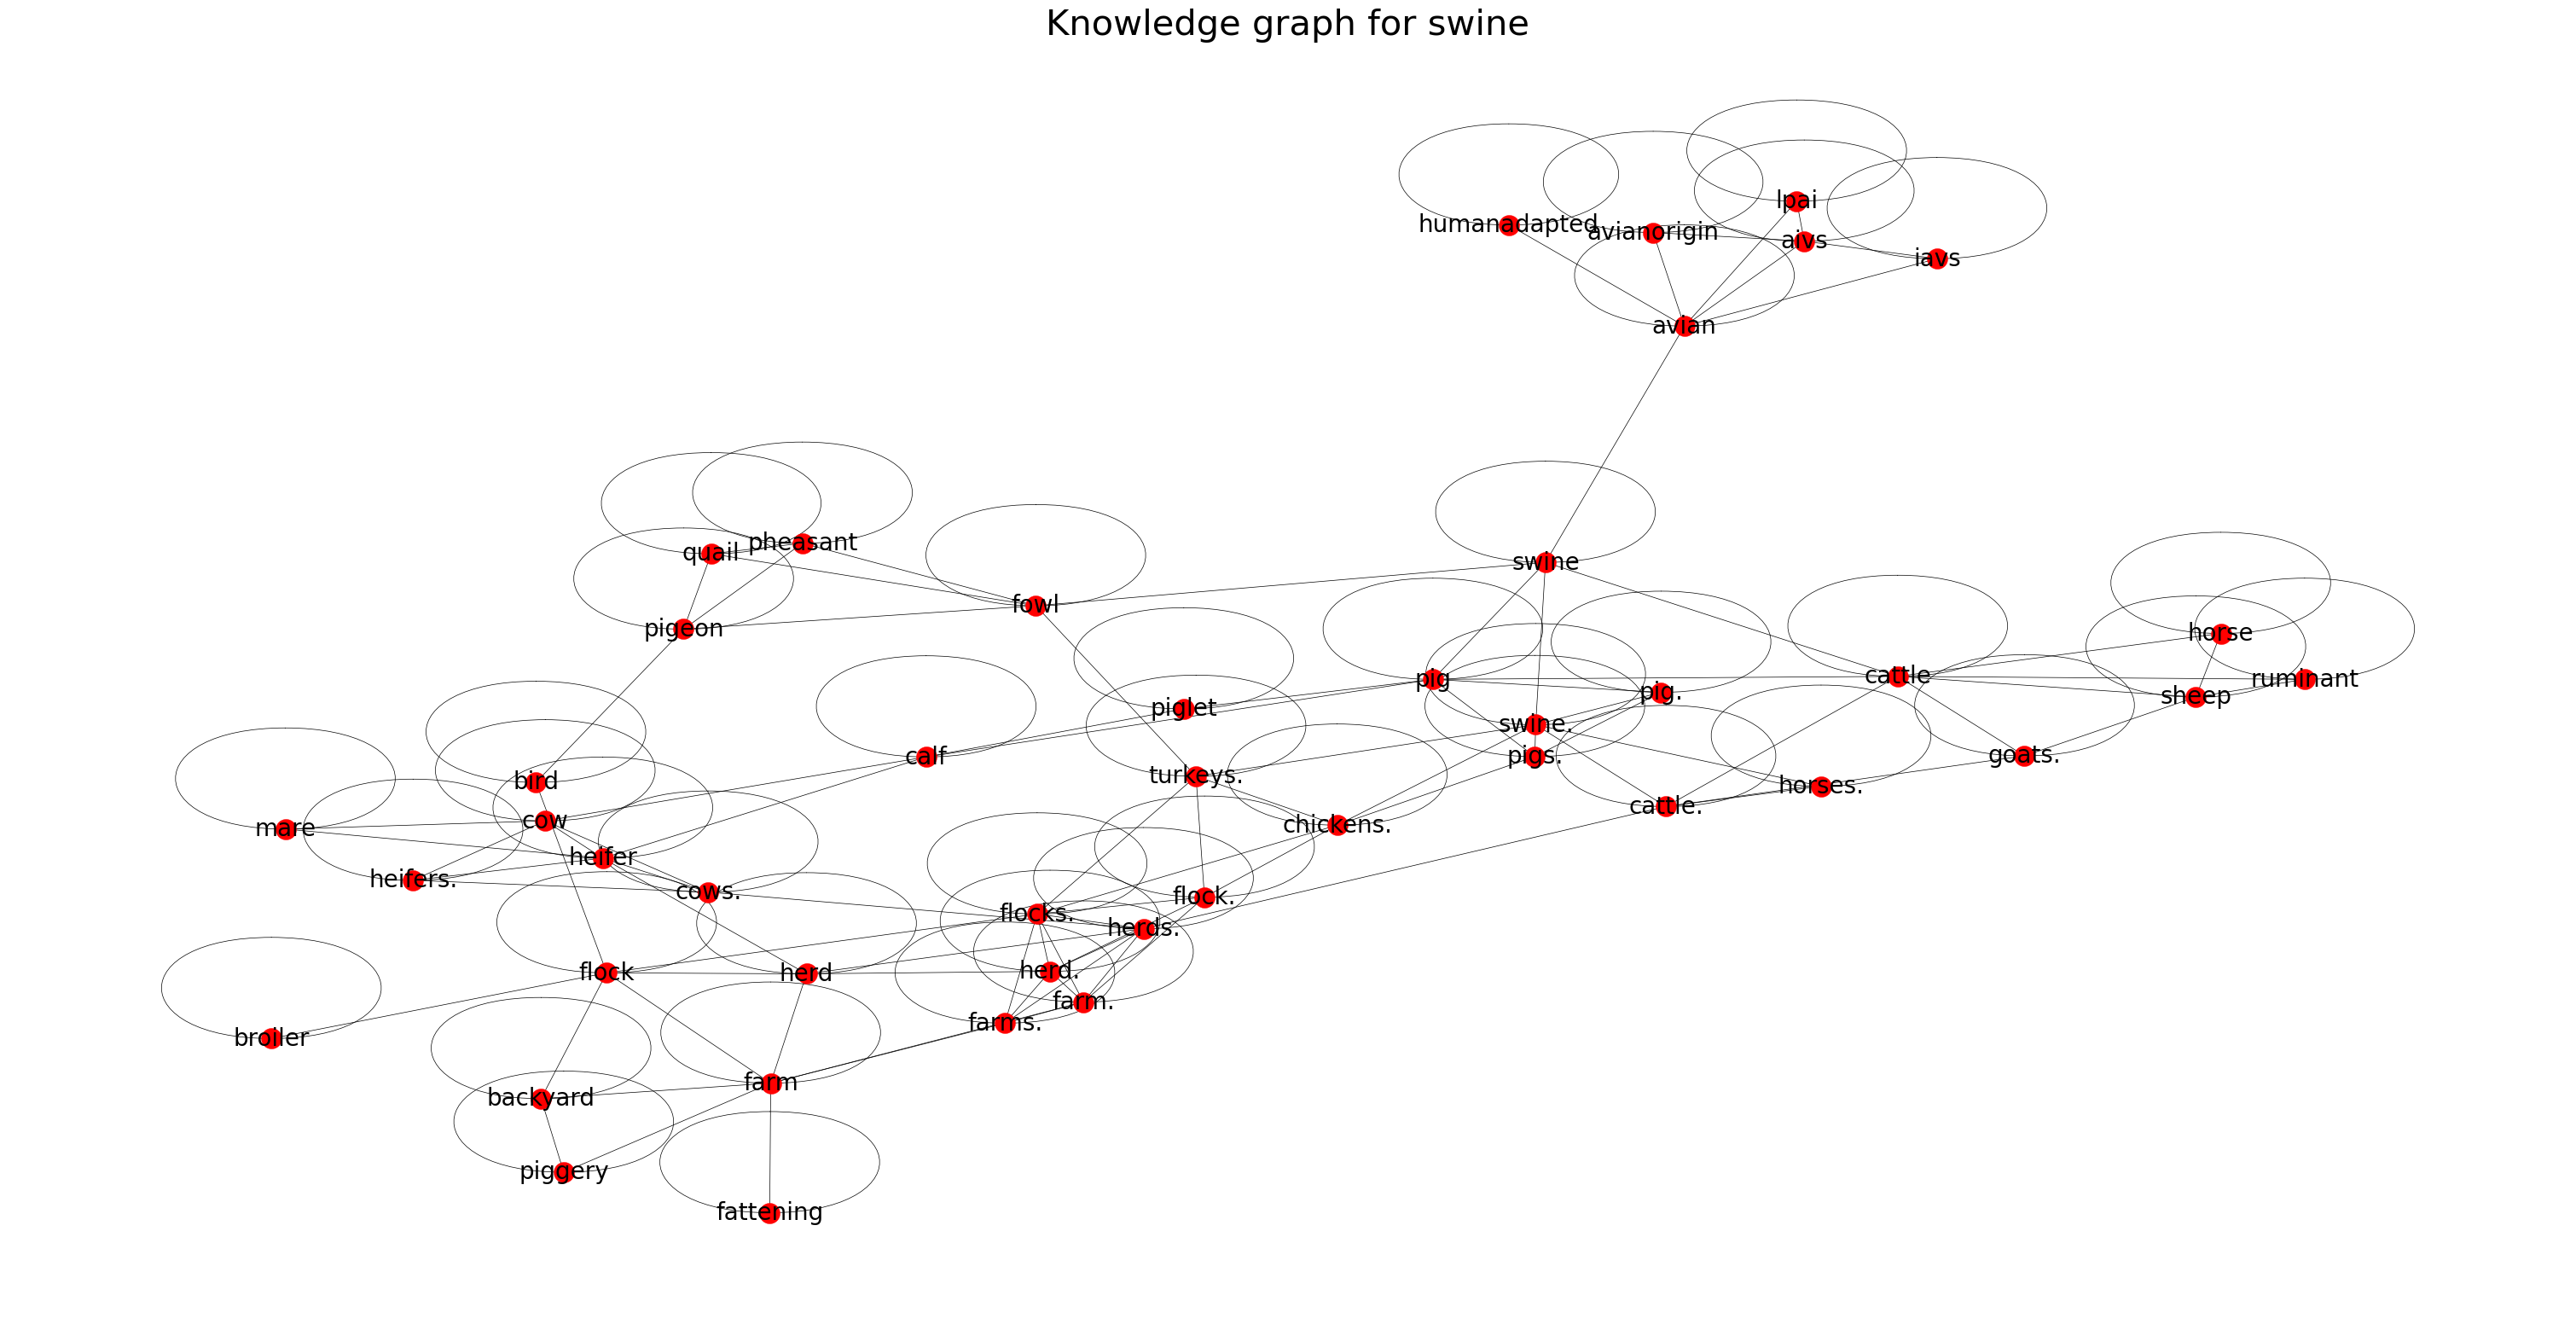

In [60]:
subgraph = nx.node_connected_component(f,'swine')
print()
nx.draw(g.subgraph(subgraph), with_labels=True, **options)
plt.title('Knowledge graph for swine', fontsize = 30)
plt.show()

### Preparedness

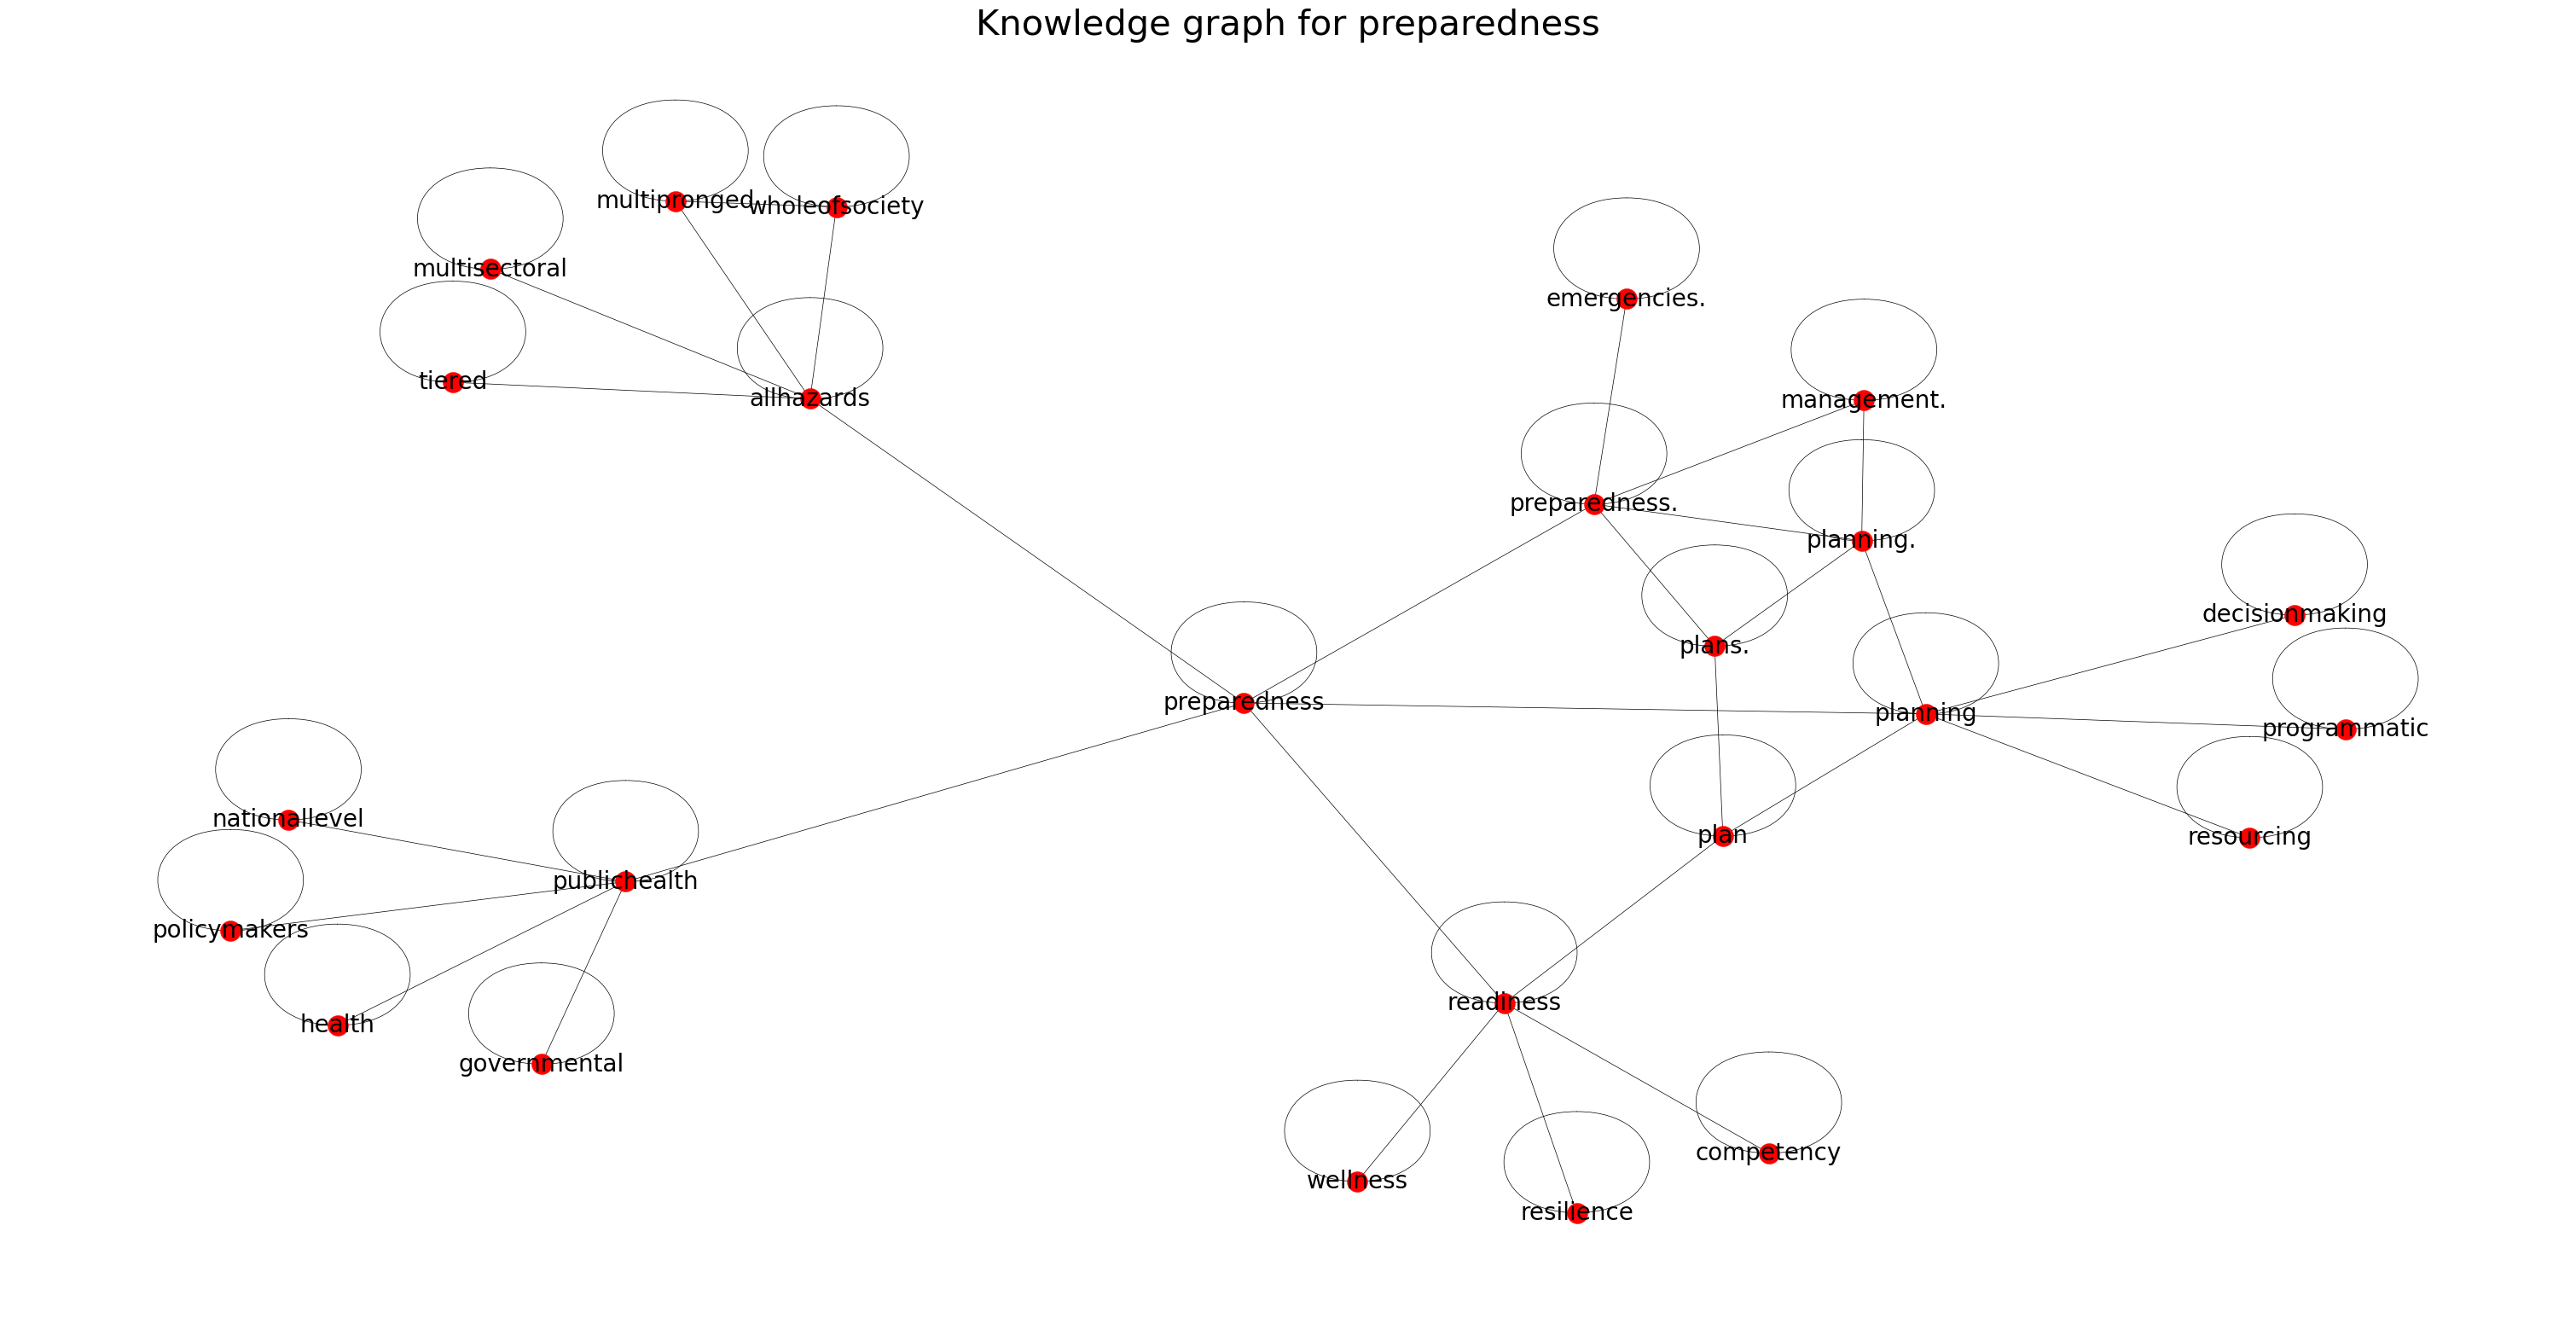

In [61]:
subgraph = nx.node_connected_component(f,'preparedness')
print()
nx.draw(g.subgraph(subgraph), with_labels=True, **options)
plt.title('Knowledge graph for preparedness', fontsize = 30)
plt.show()

### Lung

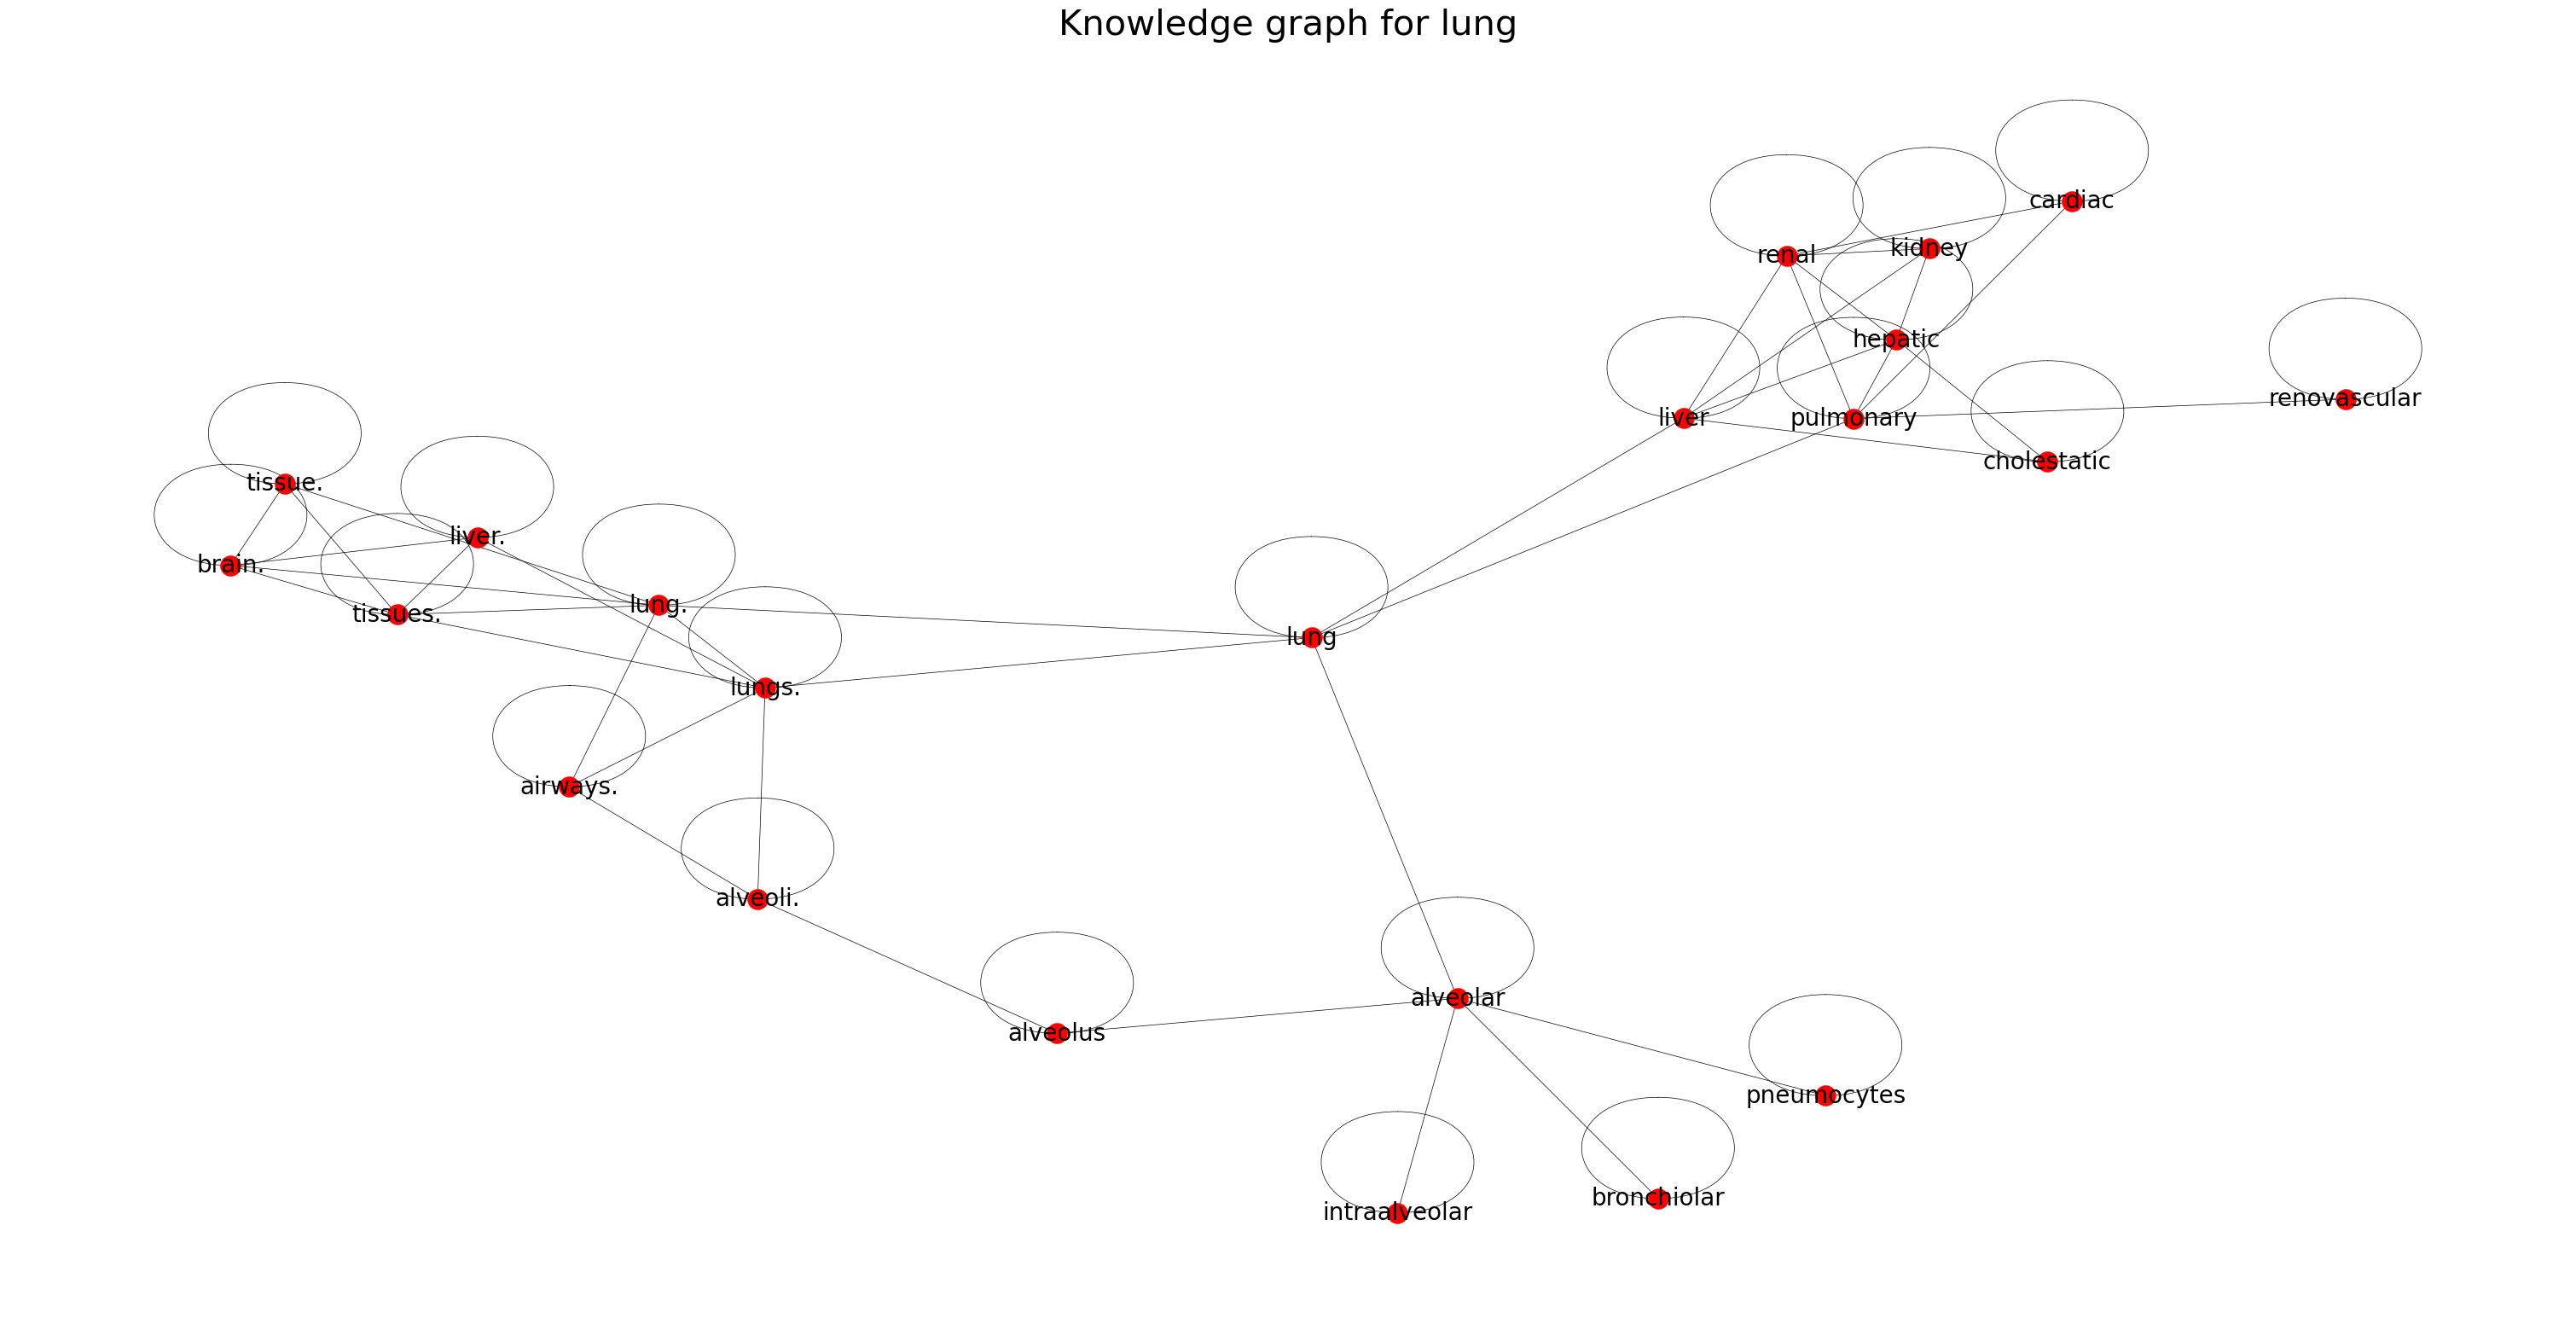

In [62]:
subgraph = nx.node_connected_component(f,'lung')
print()
nx.draw(g.subgraph(subgraph), with_labels=True, **options)
plt.title('Knowledge graph for lung', fontsize = 30)
plt.show()

### Symptom

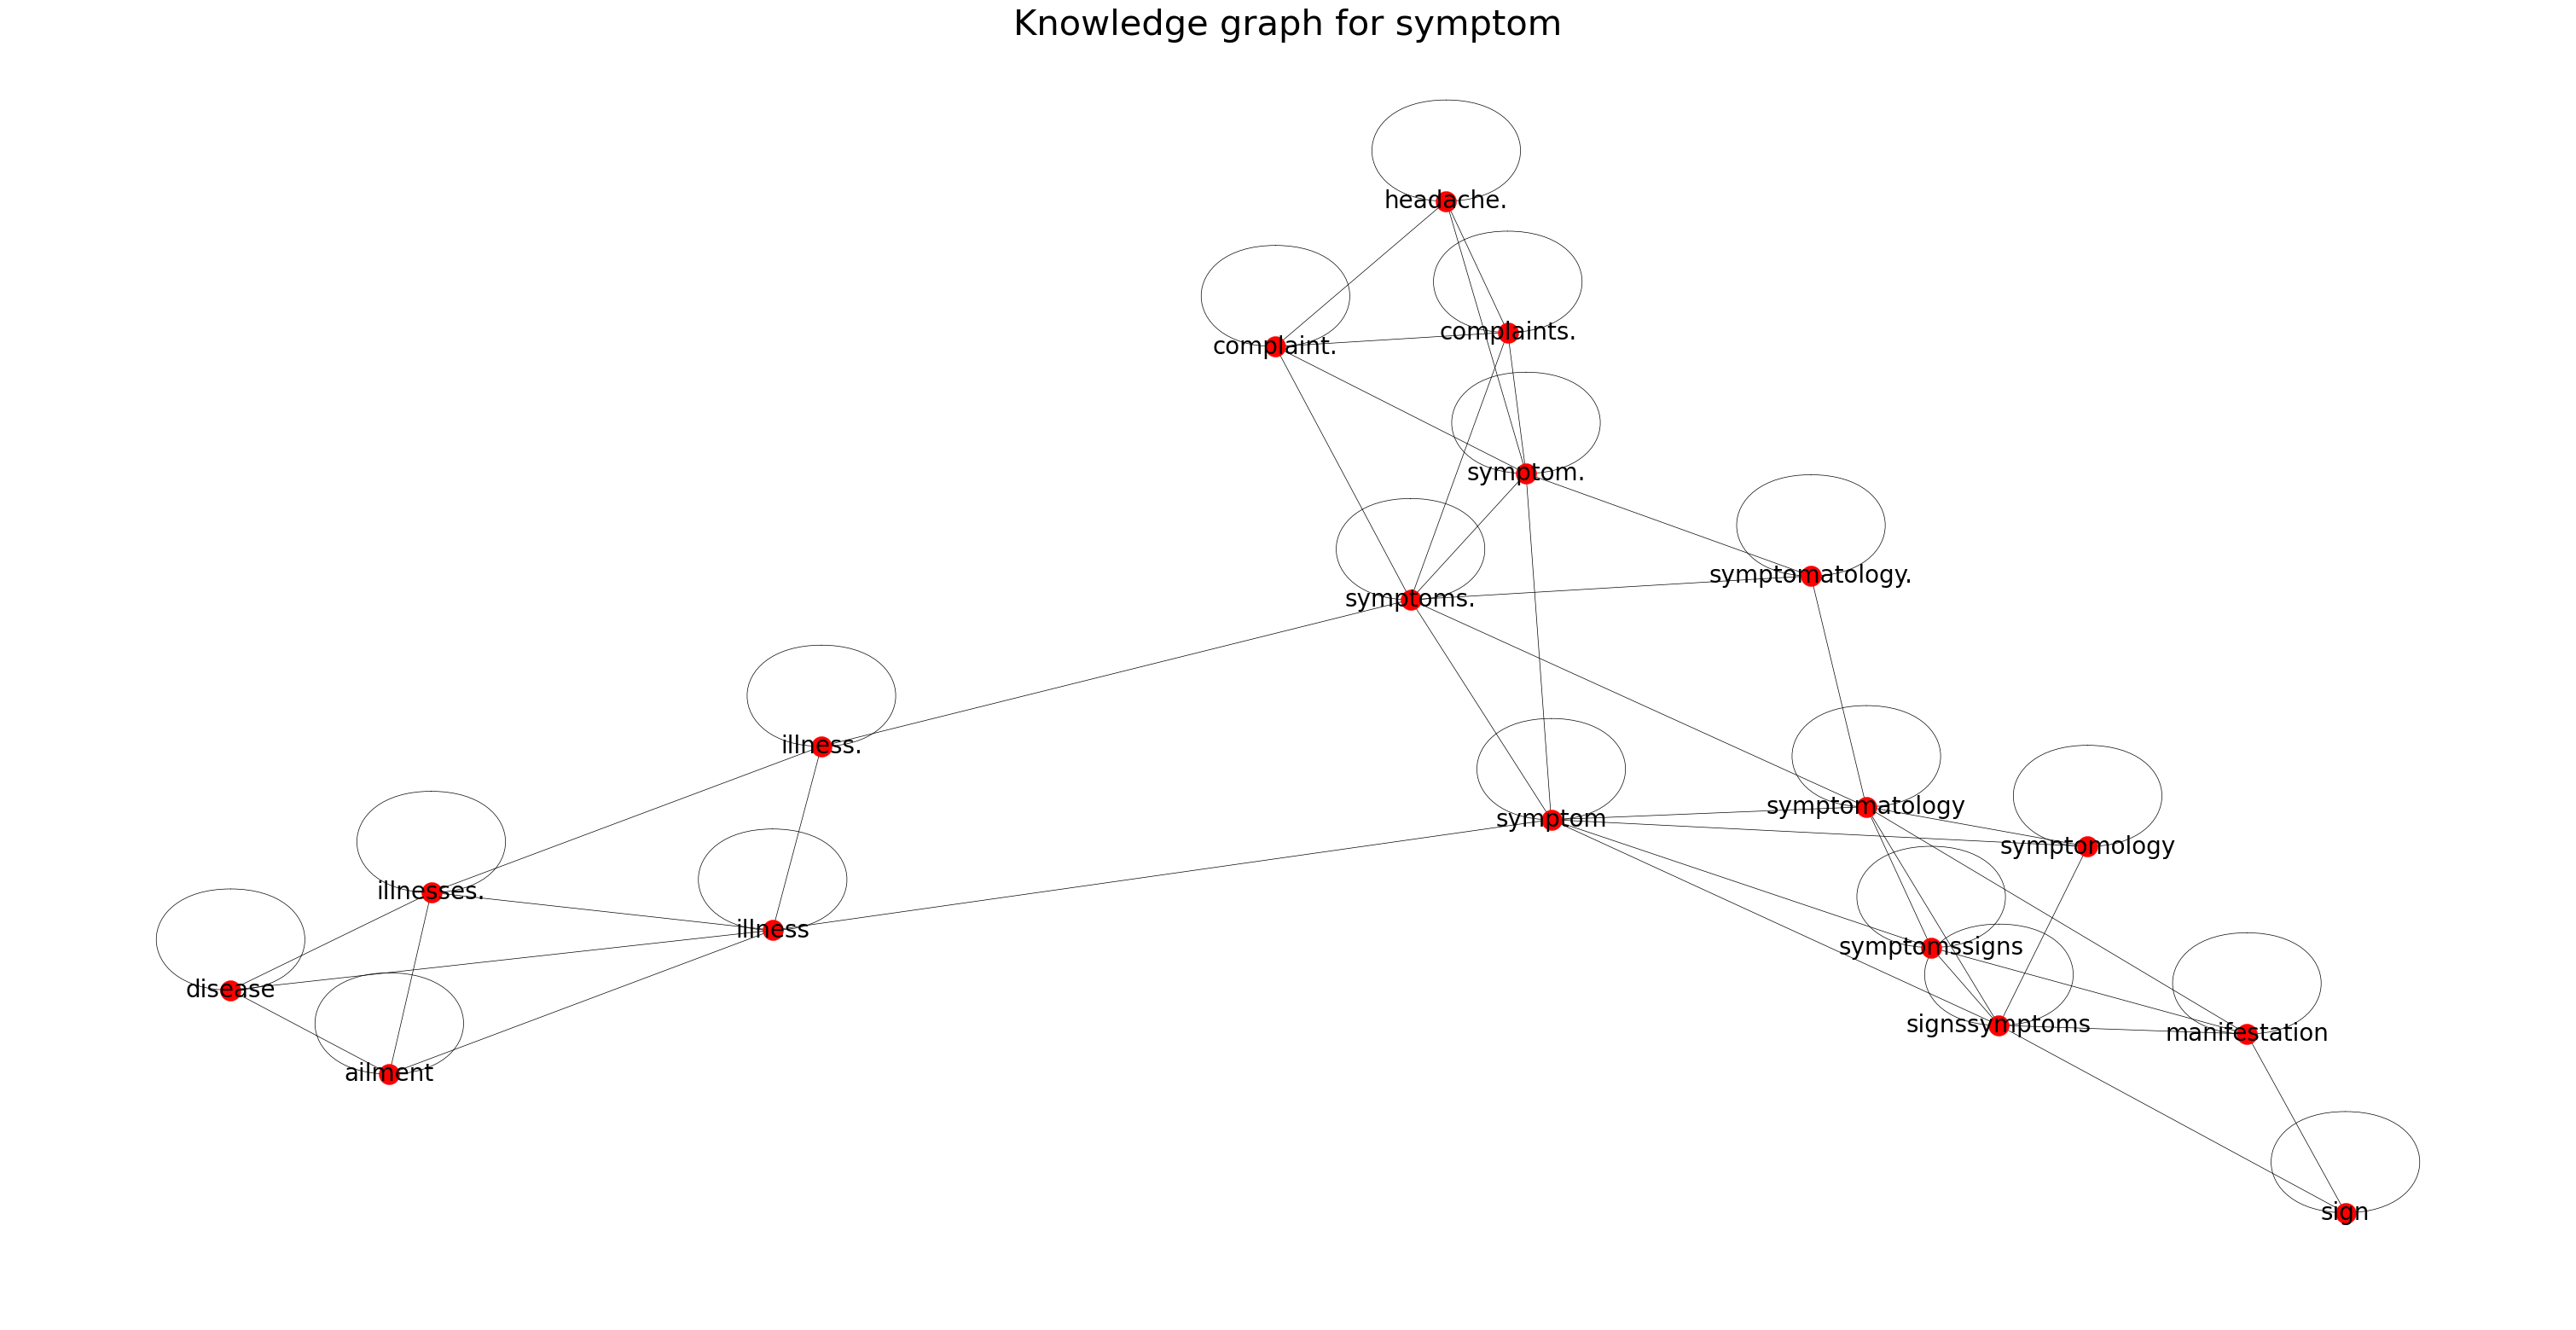

In [63]:
subgraph = nx.node_connected_component(f,'symptom')
print()
nx.draw(g.subgraph(subgraph), with_labels=True, **options)
plt.title('Knowledge graph for symptom', fontsize = 30)
plt.show()

### Transmission

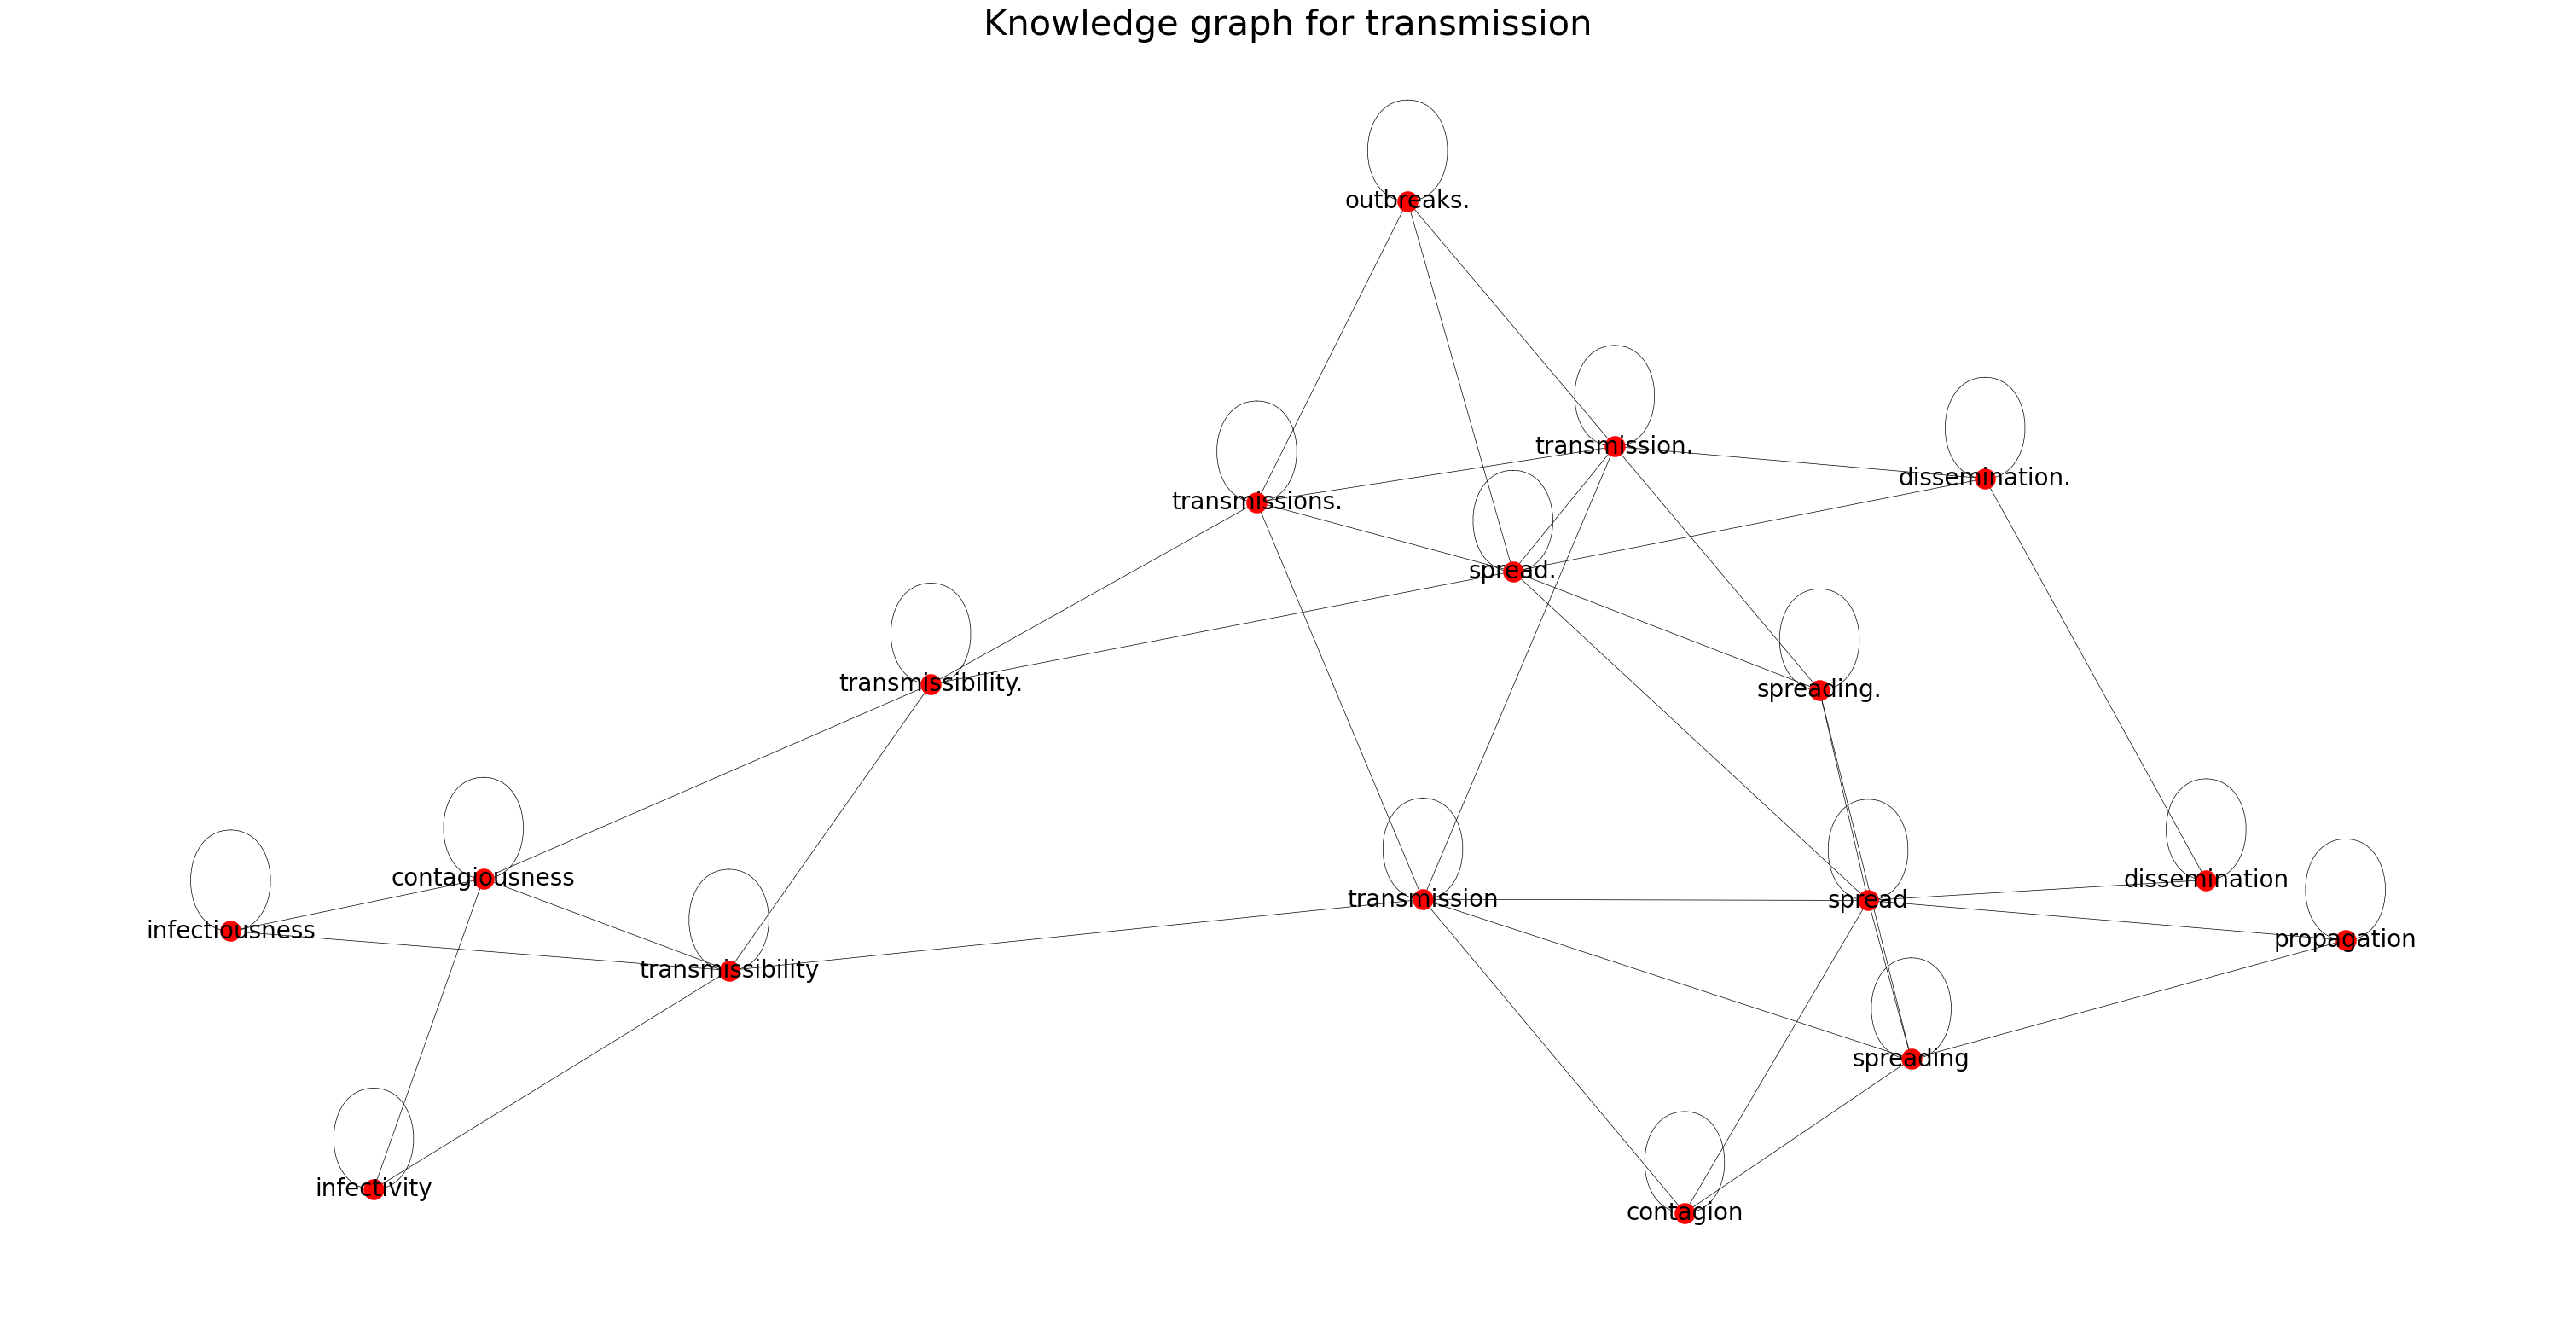

In [64]:
subgraph = nx.node_connected_component(f,'transmission')
print()
nx.draw(g.subgraph(subgraph), with_labels=True, **options)
plt.title('Knowledge graph for transmission', fontsize = 30)
plt.show()

### Infectious

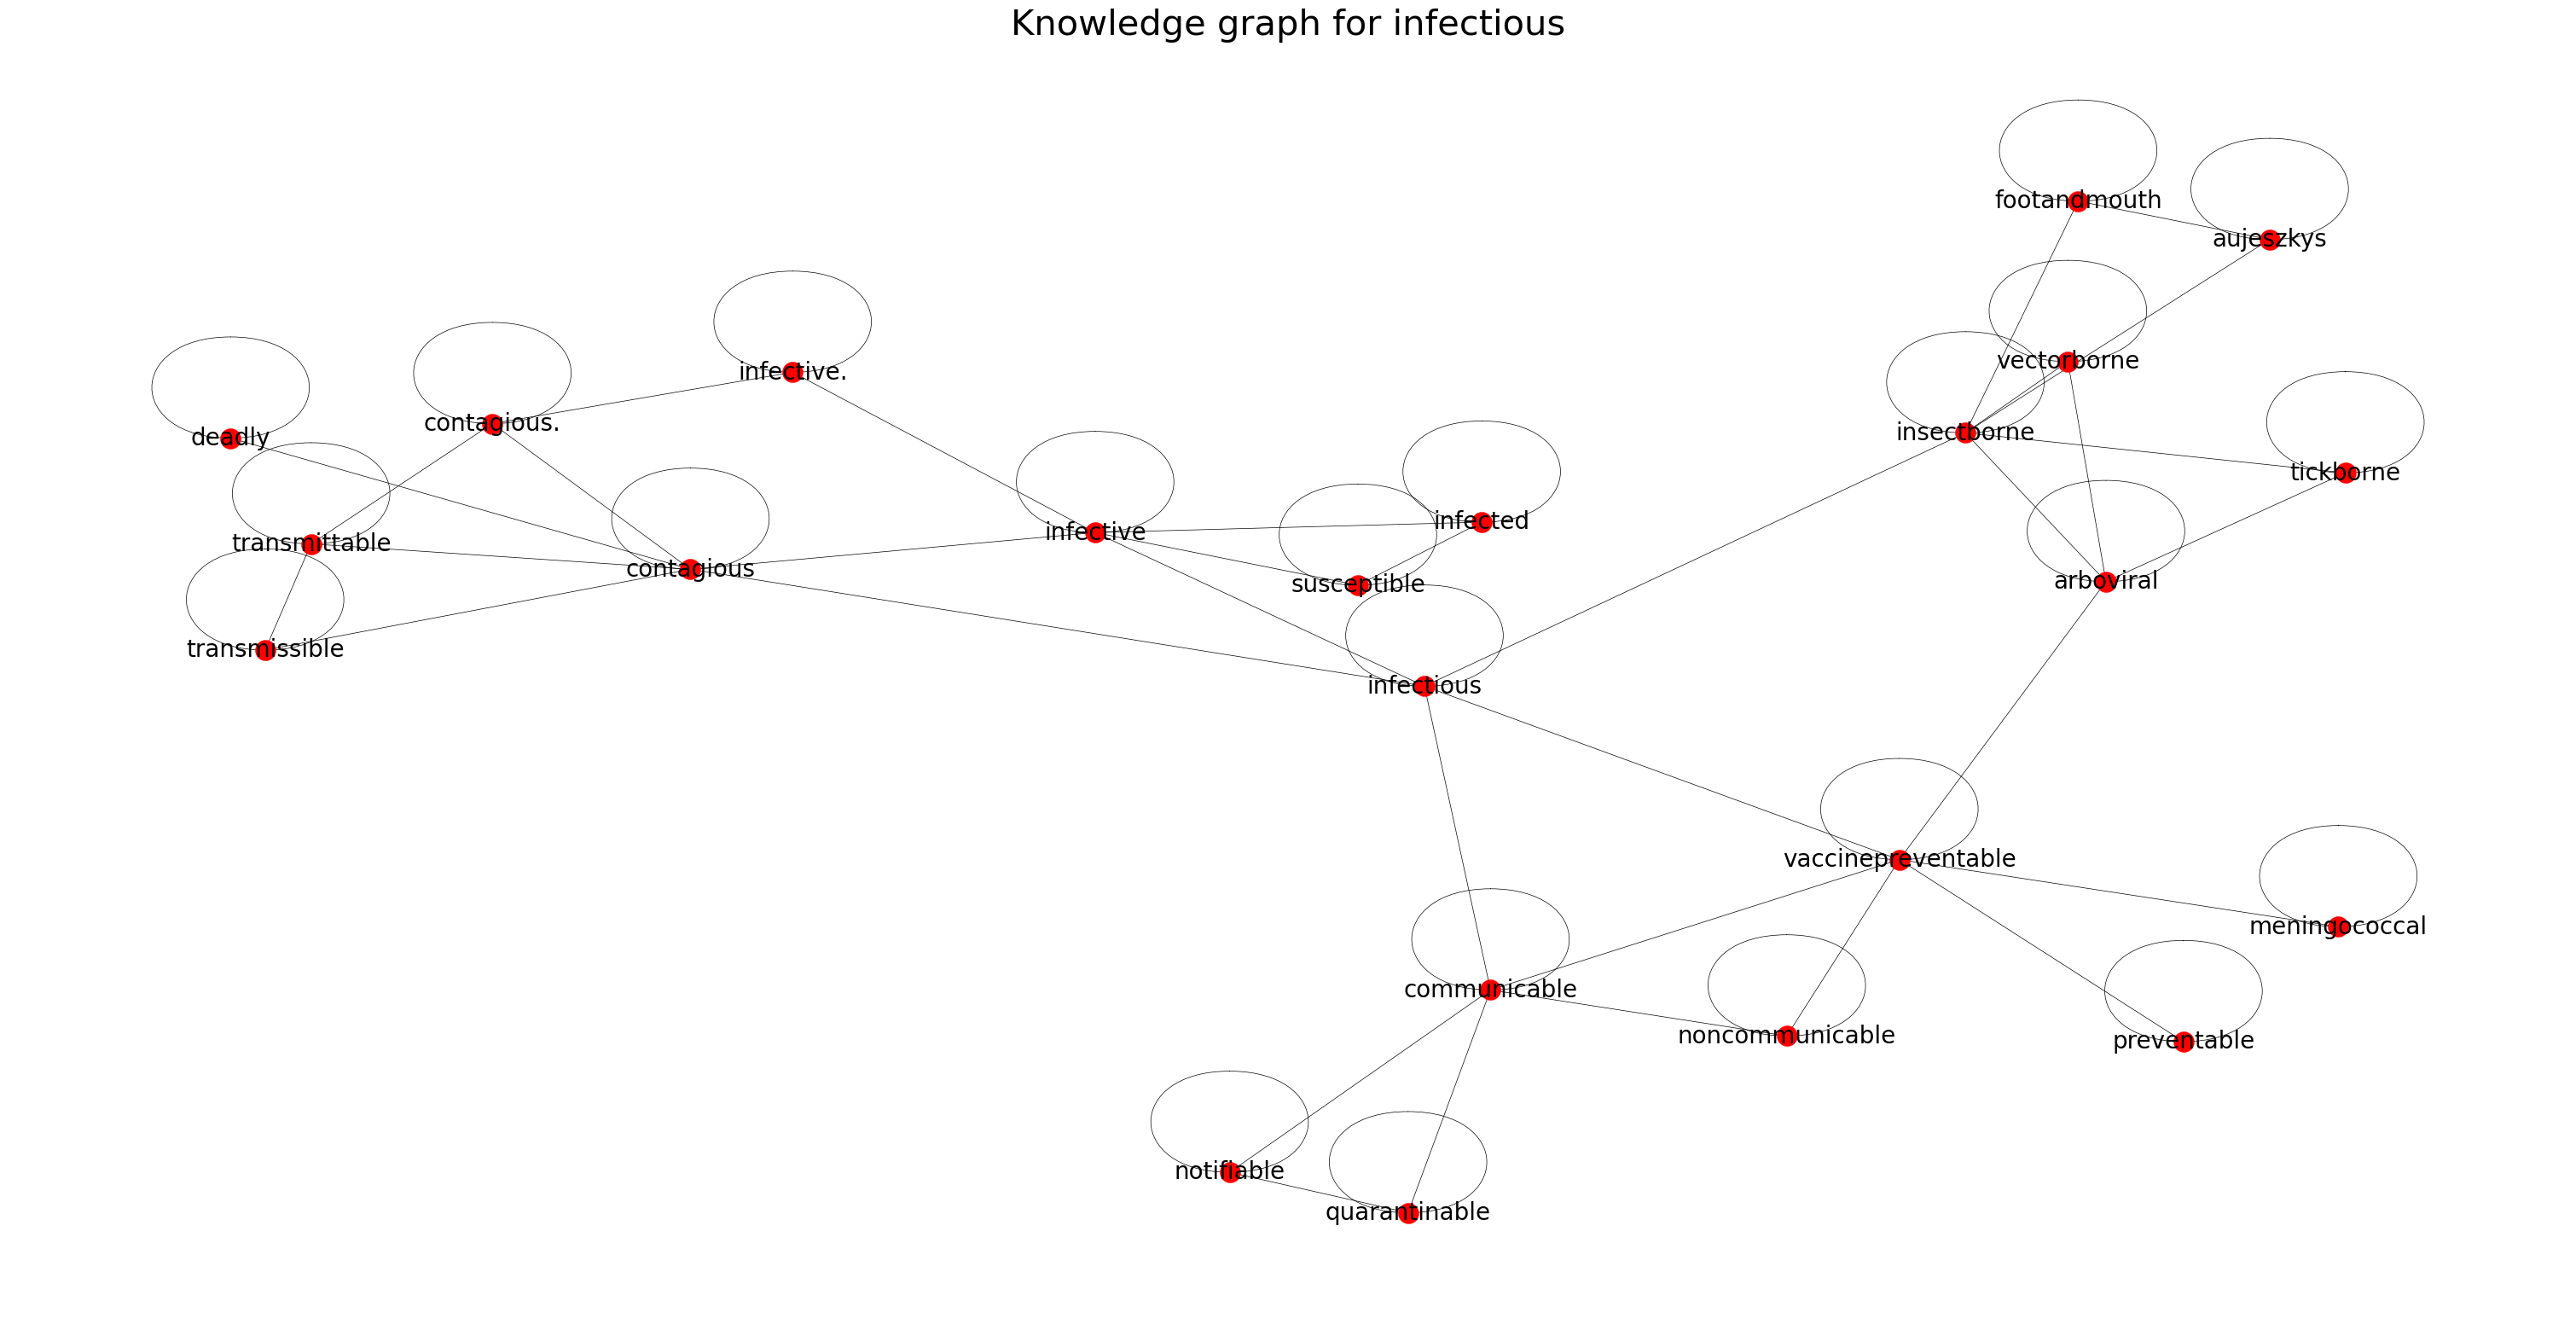

In [65]:
subgraph = nx.node_connected_component(f,'infectious')
print()
nx.draw(g.subgraph(subgraph), with_labels=True, **options)
plt.title('Knowledge graph for infectious', fontsize = 30)
plt.show()